# Detecting rhythmicity in male and female SCENIC results

## males

In [ ]:
# merge_and_plot_MetaCycle_results.R
# This script merges three MetaCycle output runs, computes average p-values and circular mean phases,
# and visualizes rhythmic TF activity across cell types and conditions.

# 1) Load required libraries
library(dplyr)
library(tidyr)
library(ggplot2)

# 2) Read the three MetaCycle result files
combined_1 <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/all_MetaCycle_TF_rhythmicity_M_1.csv", stringsAsFactors = FALSE)
combined_2 <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/all_MetaCycle_TF_rhythmicity_M_2.csv", stringsAsFactors = FALSE)
combined_3 <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/all_MetaCycle_TF_rhythmicity_M_3.csv", stringsAsFactors = FALSE)

# 3) Define circular mean function for phase (0–24 h)
circ_mean_hours <- function(phases) {
  radians <- phases/24 * 2 * pi
  mean_angle <- atan2(mean(sin(radians), na.rm=TRUE), mean(cos(radians), na.rm=TRUE))
  mean_hour <- (mean_angle %% (2*pi)) / (2*pi) * 24
  return(mean_hour)
}

# 4) Merge datasets on identifiers
id_cols <- c("CycID", "celltype", "genotype", "light_condition")
merged <- combined_1 %>%
  select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
  rename(p1 = meta2d_pvalue, phase1 = meta2d_phase) %>%
  inner_join(
    combined_2 %>% select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
      rename(p2 = meta2d_pvalue, phase2 = meta2d_phase),
    by = id_cols
  ) %>%
  inner_join(
    combined_3 %>% select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
      rename(p3 = meta2d_pvalue, phase3 = meta2d_phase),
    by = id_cols
  )

# 5) Compute average p-value and phase
merged <- merged %>%
  rowwise() %>%
  mutate(
    avg_p = mean(c(p1, p2, p3), na.rm = TRUE),
    avg_phase = circ_mean_hours(c(phase1, phase2, phase3))
  ) %>%
  ungroup()
# Filter out rows with NA in any of the three p-values
merged <- merged %>%
  filter(!is.na(p1) & !is.na(p2) & !is.na(p3))

# 6) Save merged averaged results
write.csv(merged, "TF_rhythmicity_avg_M.csv", row.names = FALSE)

# 7) Plot rhythmic TFs for each cell type and condition
sig_results <- merged %>%
  filter(avg_p < 0.05) %>%
  arrange(celltype, CycID)

sig_results$celltype <- factor(sig_results$celltype, levels = unique(sig_results$celltype))
sig_results$CycID    <- factor(sig_results$CycID, levels = unique(sig_results$CycID))

sig_results <- sig_results %>%
  mutate(Condition = paste(genotype, light_condition))

p <- ggplot(sig_results, aes(x = CycID, y = celltype,
                             color = avg_phase, size = -log10(avg_p))) +
  geom_point(alpha = 0.8) +
  scale_color_gradient(low = "yellow", high = "blue4", name = "Phase (hrs)") +
  scale_size(range = c(1, 4), name = "-log10(avg p-value)") +
  facet_wrap(~ Condition, scales = "free_y") +
  theme_minimal(base_size = 8) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
    strip.text = element_text(size = 8)
  ) +
  labs(
    title = "Rhythmic TF Activity Across Cell Types and Conditions",
    x = "Transcription Factor",
    y = "Cell Type"
  )

print(p)


In [5]:
options(repr.plot.width = 20,
        repr.plot.height = 25,
        repr.plot.res    = 500)
   # resolution in DPI

# Make background white
par(bg = "white")


In [ ]:
# 7) Define cyclic color palette
phase_colors <- hsv(seq(0, 1, length.out = 100), 1, 1)

# on your averaged tibble
sig_results$Condition <- factor(
  paste(sig_results$genotype, sig_results$light_condition),
  levels = c("Wild-type LD", "Wild-type DD", "per0 LD", "per0 DD")
)

# 8) Plot rhythmic TFs with cyclic phase scale
p <- ggplot(sig_results, aes(x = celltype, y = CycID,
                             color = avg_phase, size = -log10(avg_p))) +
  geom_point(alpha = 0.8) +
  scale_color_gradientn(
    colors = phase_colors,
    limits = c(0, 24),
    breaks = c(0, 6, 12, 18, 24),
    name = "Phase (hrs)"
  ) +
  scale_size(range = c(1, 4), name = "-log10(avg p-value)") +
  facet_wrap(~ Condition, scales = "free_y") +
  theme_minimal(base_size = 6) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
    strip.text   = element_text(size = 8)
  ) +
  labs(
    title = "Rhythmic TF Activity Across Cell Types and Conditions",
    x = "Transcription Factor",
    y = "Cell Type"
  )

print(p)

In [7]:
options(repr.plot.width = 6,
        repr.plot.height = 4,
        repr.plot.res    = 500)
   # resolution in DPI

# Make background white
par(bg = "white")


In [8]:
library(stringr)

sig_results <- sig_results %>%
  mutate(CycID = str_remove(CycID, "\\.{3}$"))


library(dplyr)
  #filter(genotype == "Wild-type", light == "LD")

# Count how many unique rhythmic TF activities were detected in WT DD
n_rhythmic <- sig_results %>% pull(CycID) %>% unique() %>% length()
cat("Total number of rhythmic TF activities detected:", n_rhythmic, "\n")

# For each TF, count the number of unique cell types in which it appears
tf_abundance <- sig_results %>%
  group_by(CycID) %>%
  summarize(num_celltypes = n_distinct(celltype), .groups = "drop") %>%
  arrange(desc(num_celltypes))

# Get the top 17 TFs that are most abundant (detected in the highest number of cell types)
top_20_tf <- tf_abundance %>% slice_head(n = 54)

# Display the top 17 TFs
print(top_20_tf)


Total number of rhythmic TF activities detected: 202 
# A tibble: 54 × 2
   CycID   num_celltypes
   <chr>           <int>
 1 Parp               30
 2 cwo                30
 3 srp                28
 4 Sox102F            27
 5 luna               27
 6 onecut             27
 7 Hr38               26
 8 Mitf               25
 9 vri                25
10 NfI                24
# ℹ 44 more rows


In [9]:
print(top_20_tf$CycID)

 [1] "Parp"         "cwo"          "srp"          "Sox102F"      "luna"        
 [6] "onecut"       "Hr38"         "Mitf"         "vri"          "NfI"         
[11] "Eip78C"       "Hnf4"         "ken"          "Pur.alpha"    "retn"        
[16] "scro"         "zfh2"         "klu"          "pnr"          "CycT"        
[21] "Dr"           "GATAd"        "Pdp1"         "hbn"          "jim"         
[26] "lola"         "vis"          "CrebB"        "Nf.YA"        "Stat92E"     
[31] "pb"           "Atf3"         "Poxn"         "REPTOR.BP"    "br"          
[36] "hth"          "kn"           "run"          "TFAM"         "crp"         
[41] "grh"          "hb"           "lbl"          "vnd"          "E.spl.m3.HLH"
[46] "Ets65A"       "GATAe"        "Hr78"         "Rel"          "Rfx"         
[51] "Sox21a"       "da"           "fd59A"        "fru"         


## shared TFs

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


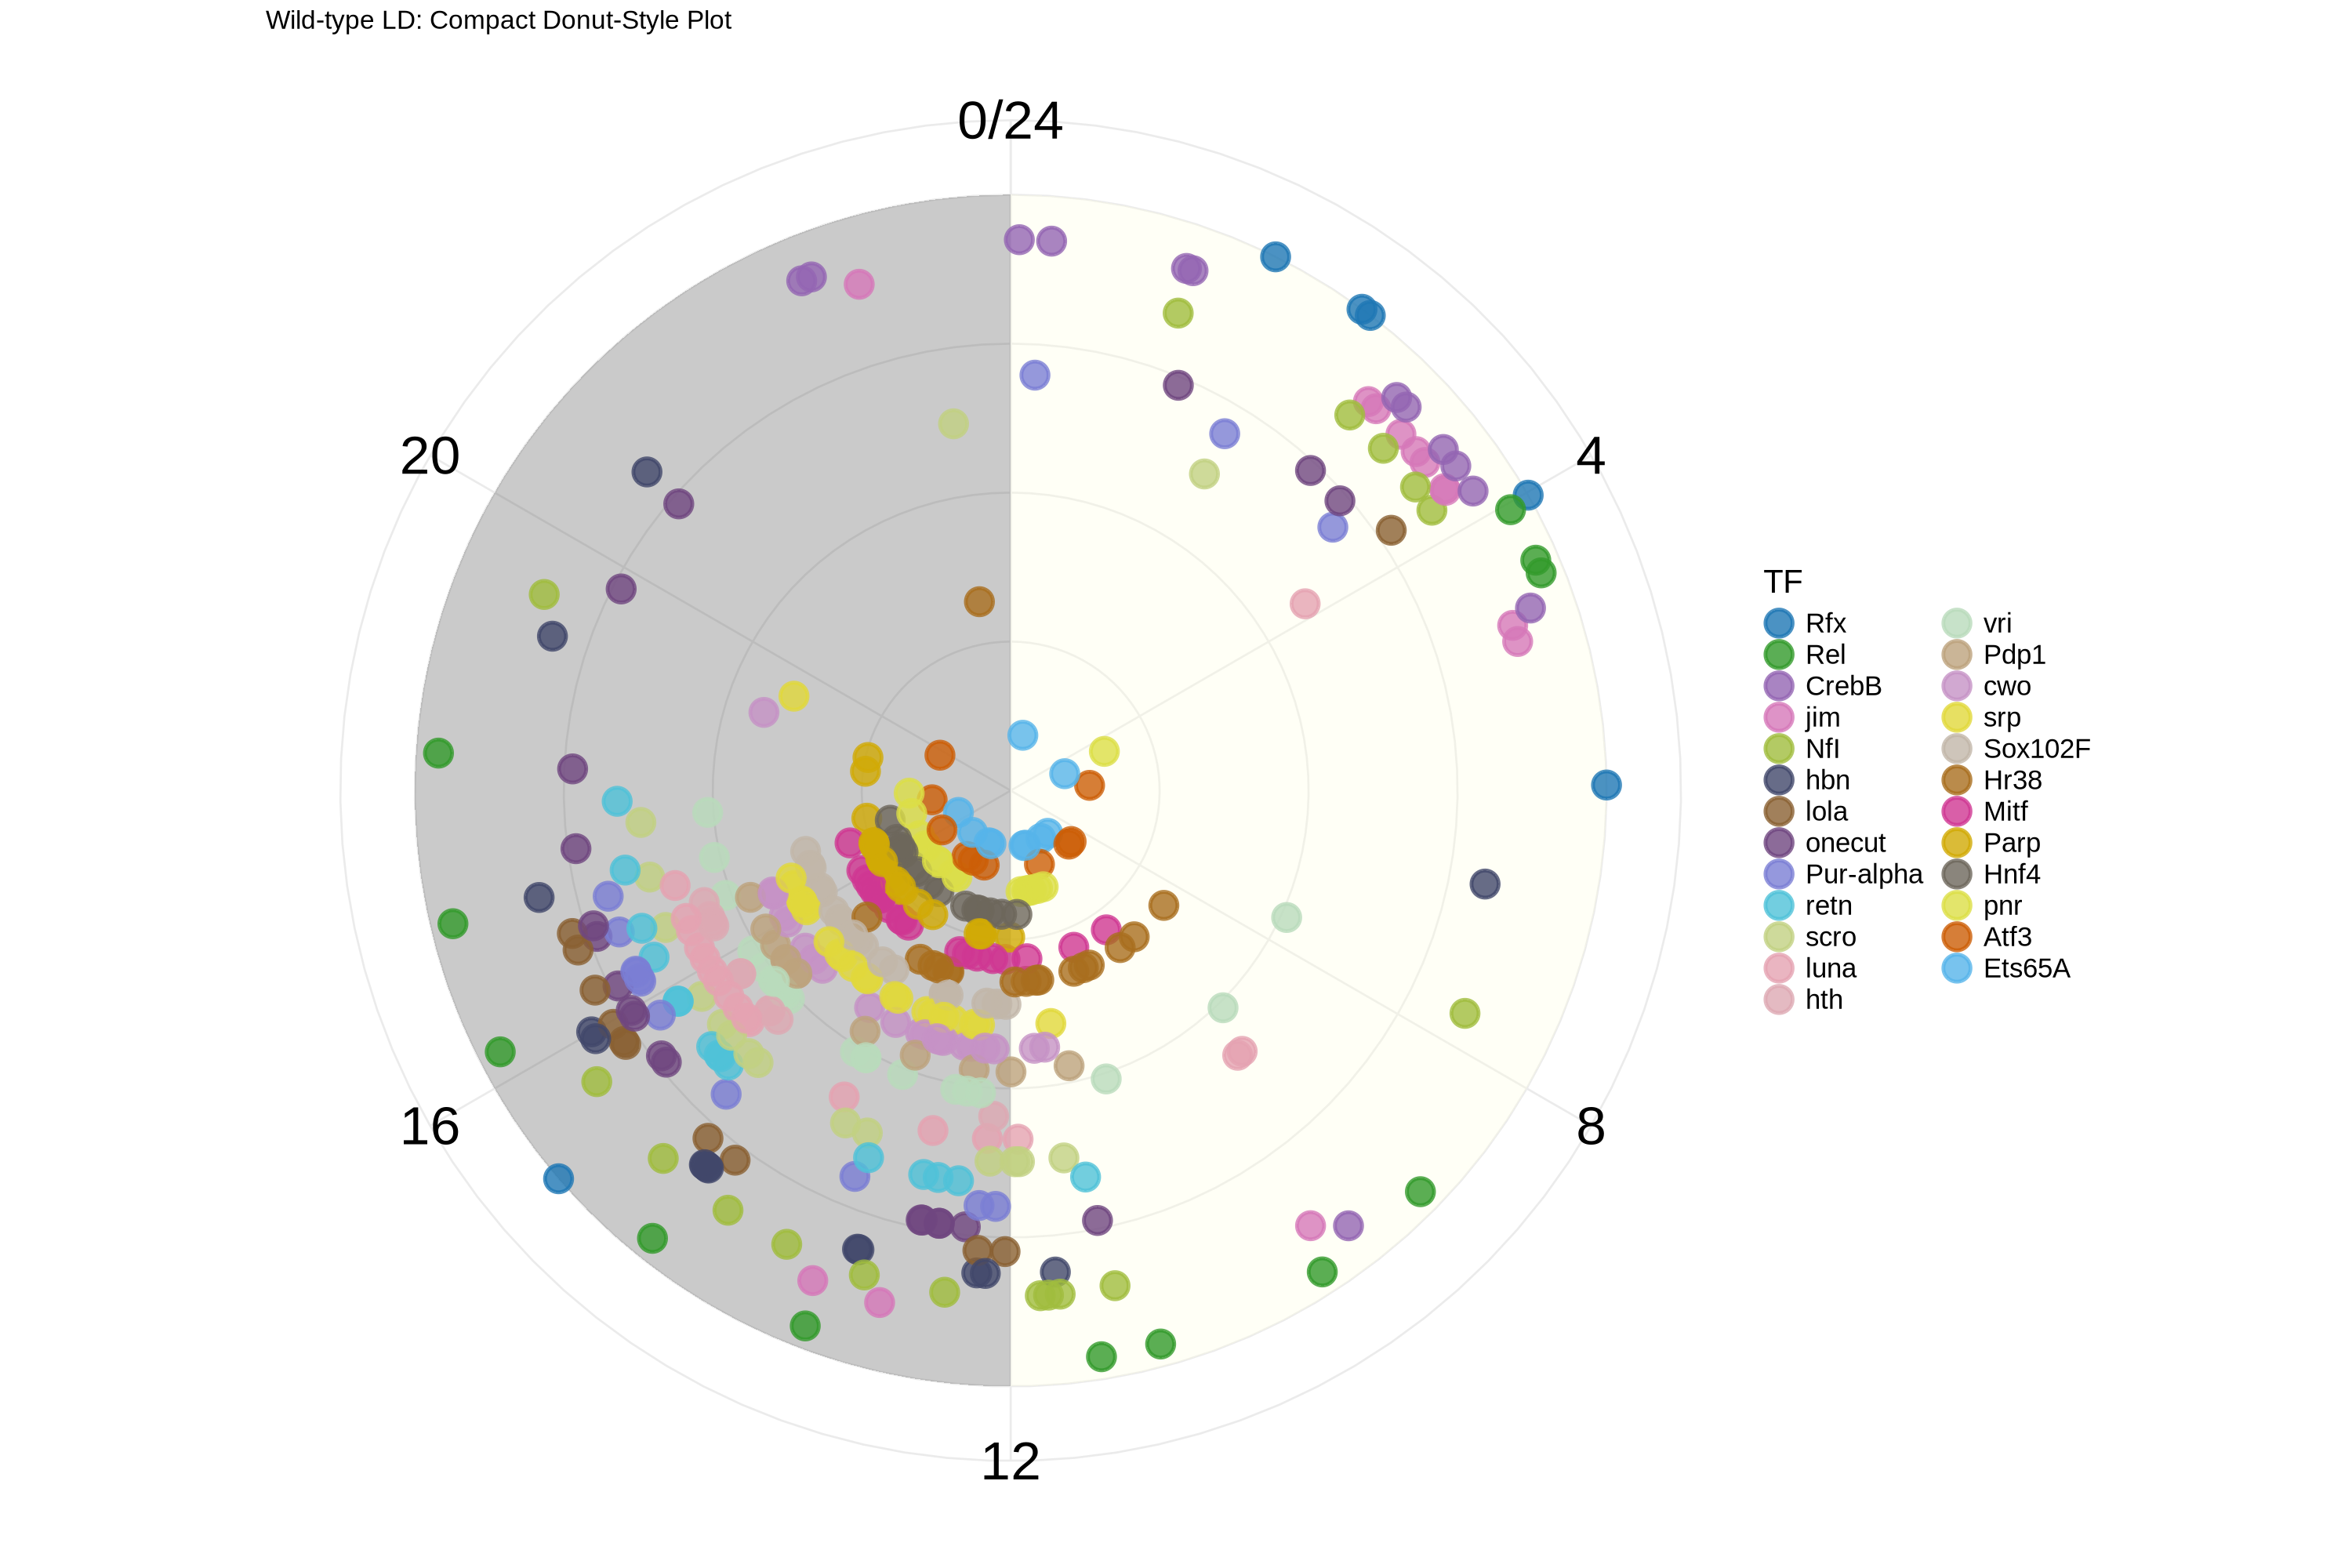

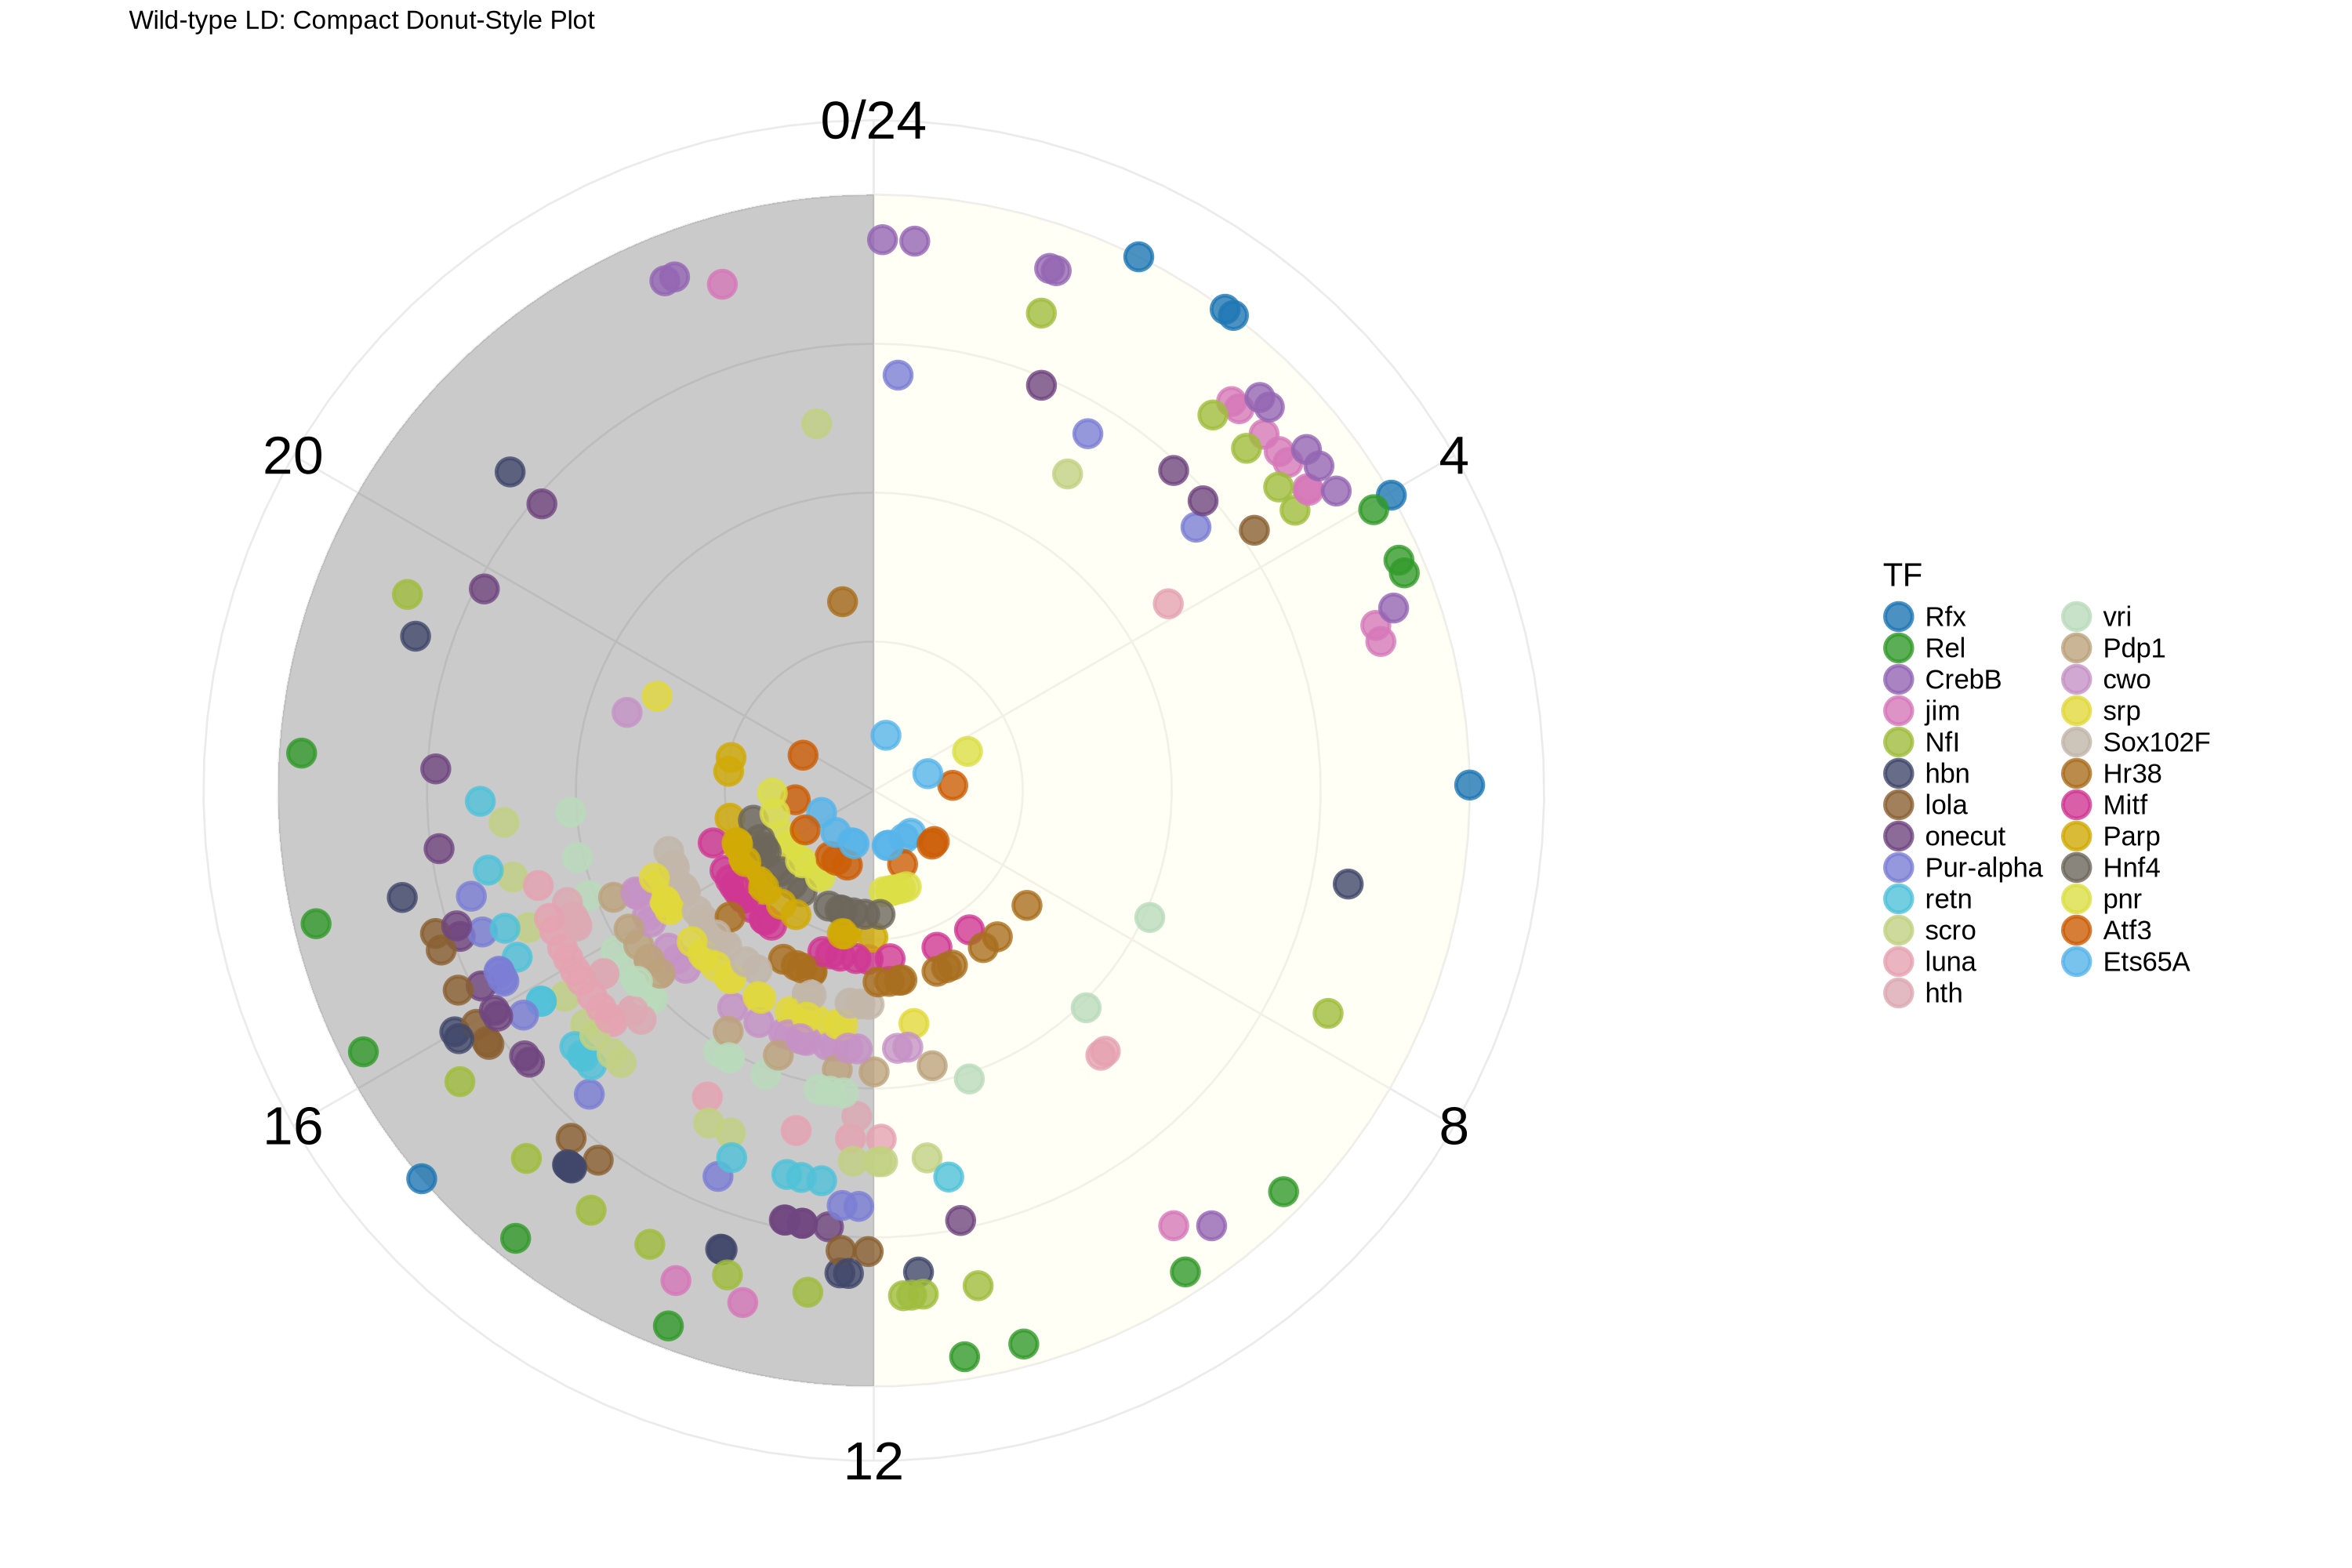

In [210]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c(
             "CrebB"
             ,"Dr"
             ,"ken"
             ,"jim"
             ,"crp"
             ,"GATAd"
             ,"br"
             ,"REPTOR.BP"

             ,"NfI"
             ,"onecut"
             ,"Rfx"
    

             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"luna"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Eip78C"
             ,"Hnf4"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"zfh2"
             ,"klu"
             ,"pnr"
             ,"CycT"
             ,"hbn"
             ,"lola"
             ,"vis"
             ,"Nf.YA"
             ,"Stat92E"
             ,"pb"
             ,"Atf3"
             ,"Poxn"
             ,"hth"
             ,"kn"
             ,"run"
             ,"TFAM"
             ,"grh"
             ,"hb"
             ,"lbl"
             ,"vnd"
             ,"E.spl.m3.HLH"
             ,"Ets65A"
             ,"GATAe"
             ,"Hr78"
             ,"Rel"
             ,"Sox21a"
             ,"da"
             ,"fd59A"
             ,"fru")


raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "E.spl.m3.HLH" = "E(spl)m3-HLH",
  "Blimp.1" = "Blimp-1",
  "Nf.YA"     = "Nf-YA",
  "Pur.alpha" = "Pur-alpha",
  "REPTOR.BP" = "REPTOR-BP"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "E.spl.m3.HLH" = "E(spl)m3-HLH",
    "Blimp.1" = "Blimp-1",
    "Nf.YA"     = "Nf-YA",
    "Pur.alpha" = "Pur-alpha",
    "REPTOR.BP" = "REPTOR-BP",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=2, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


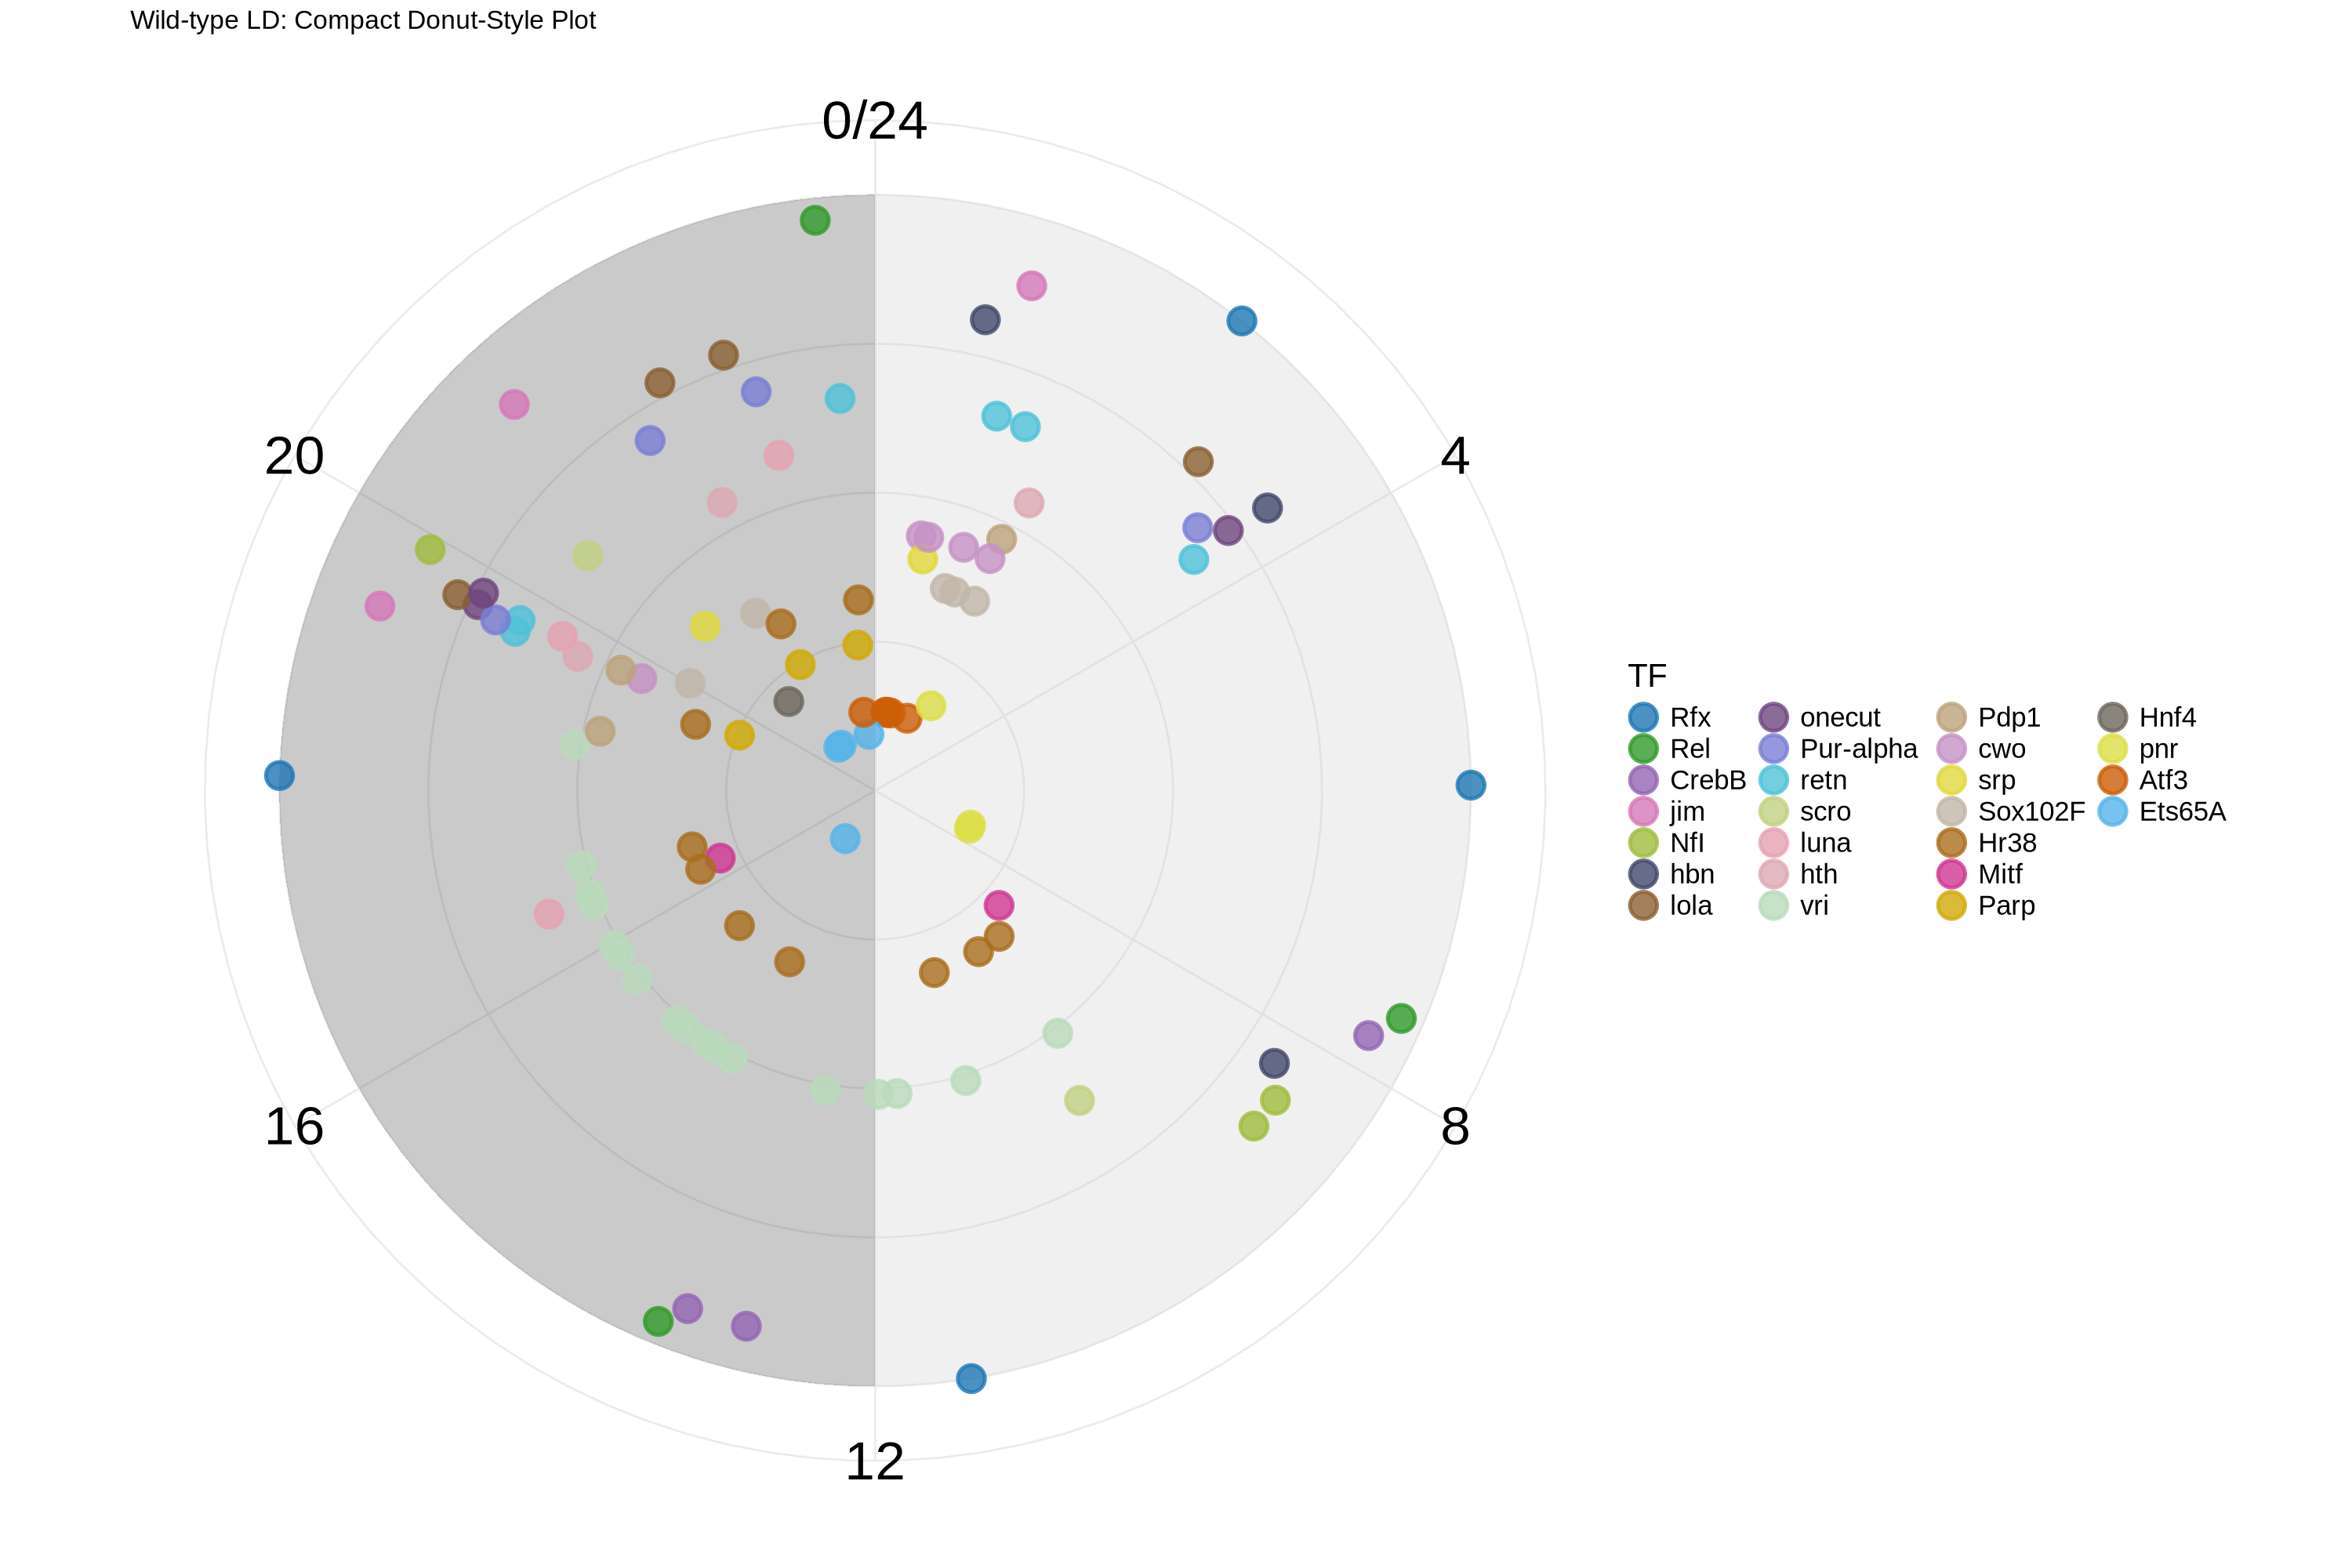

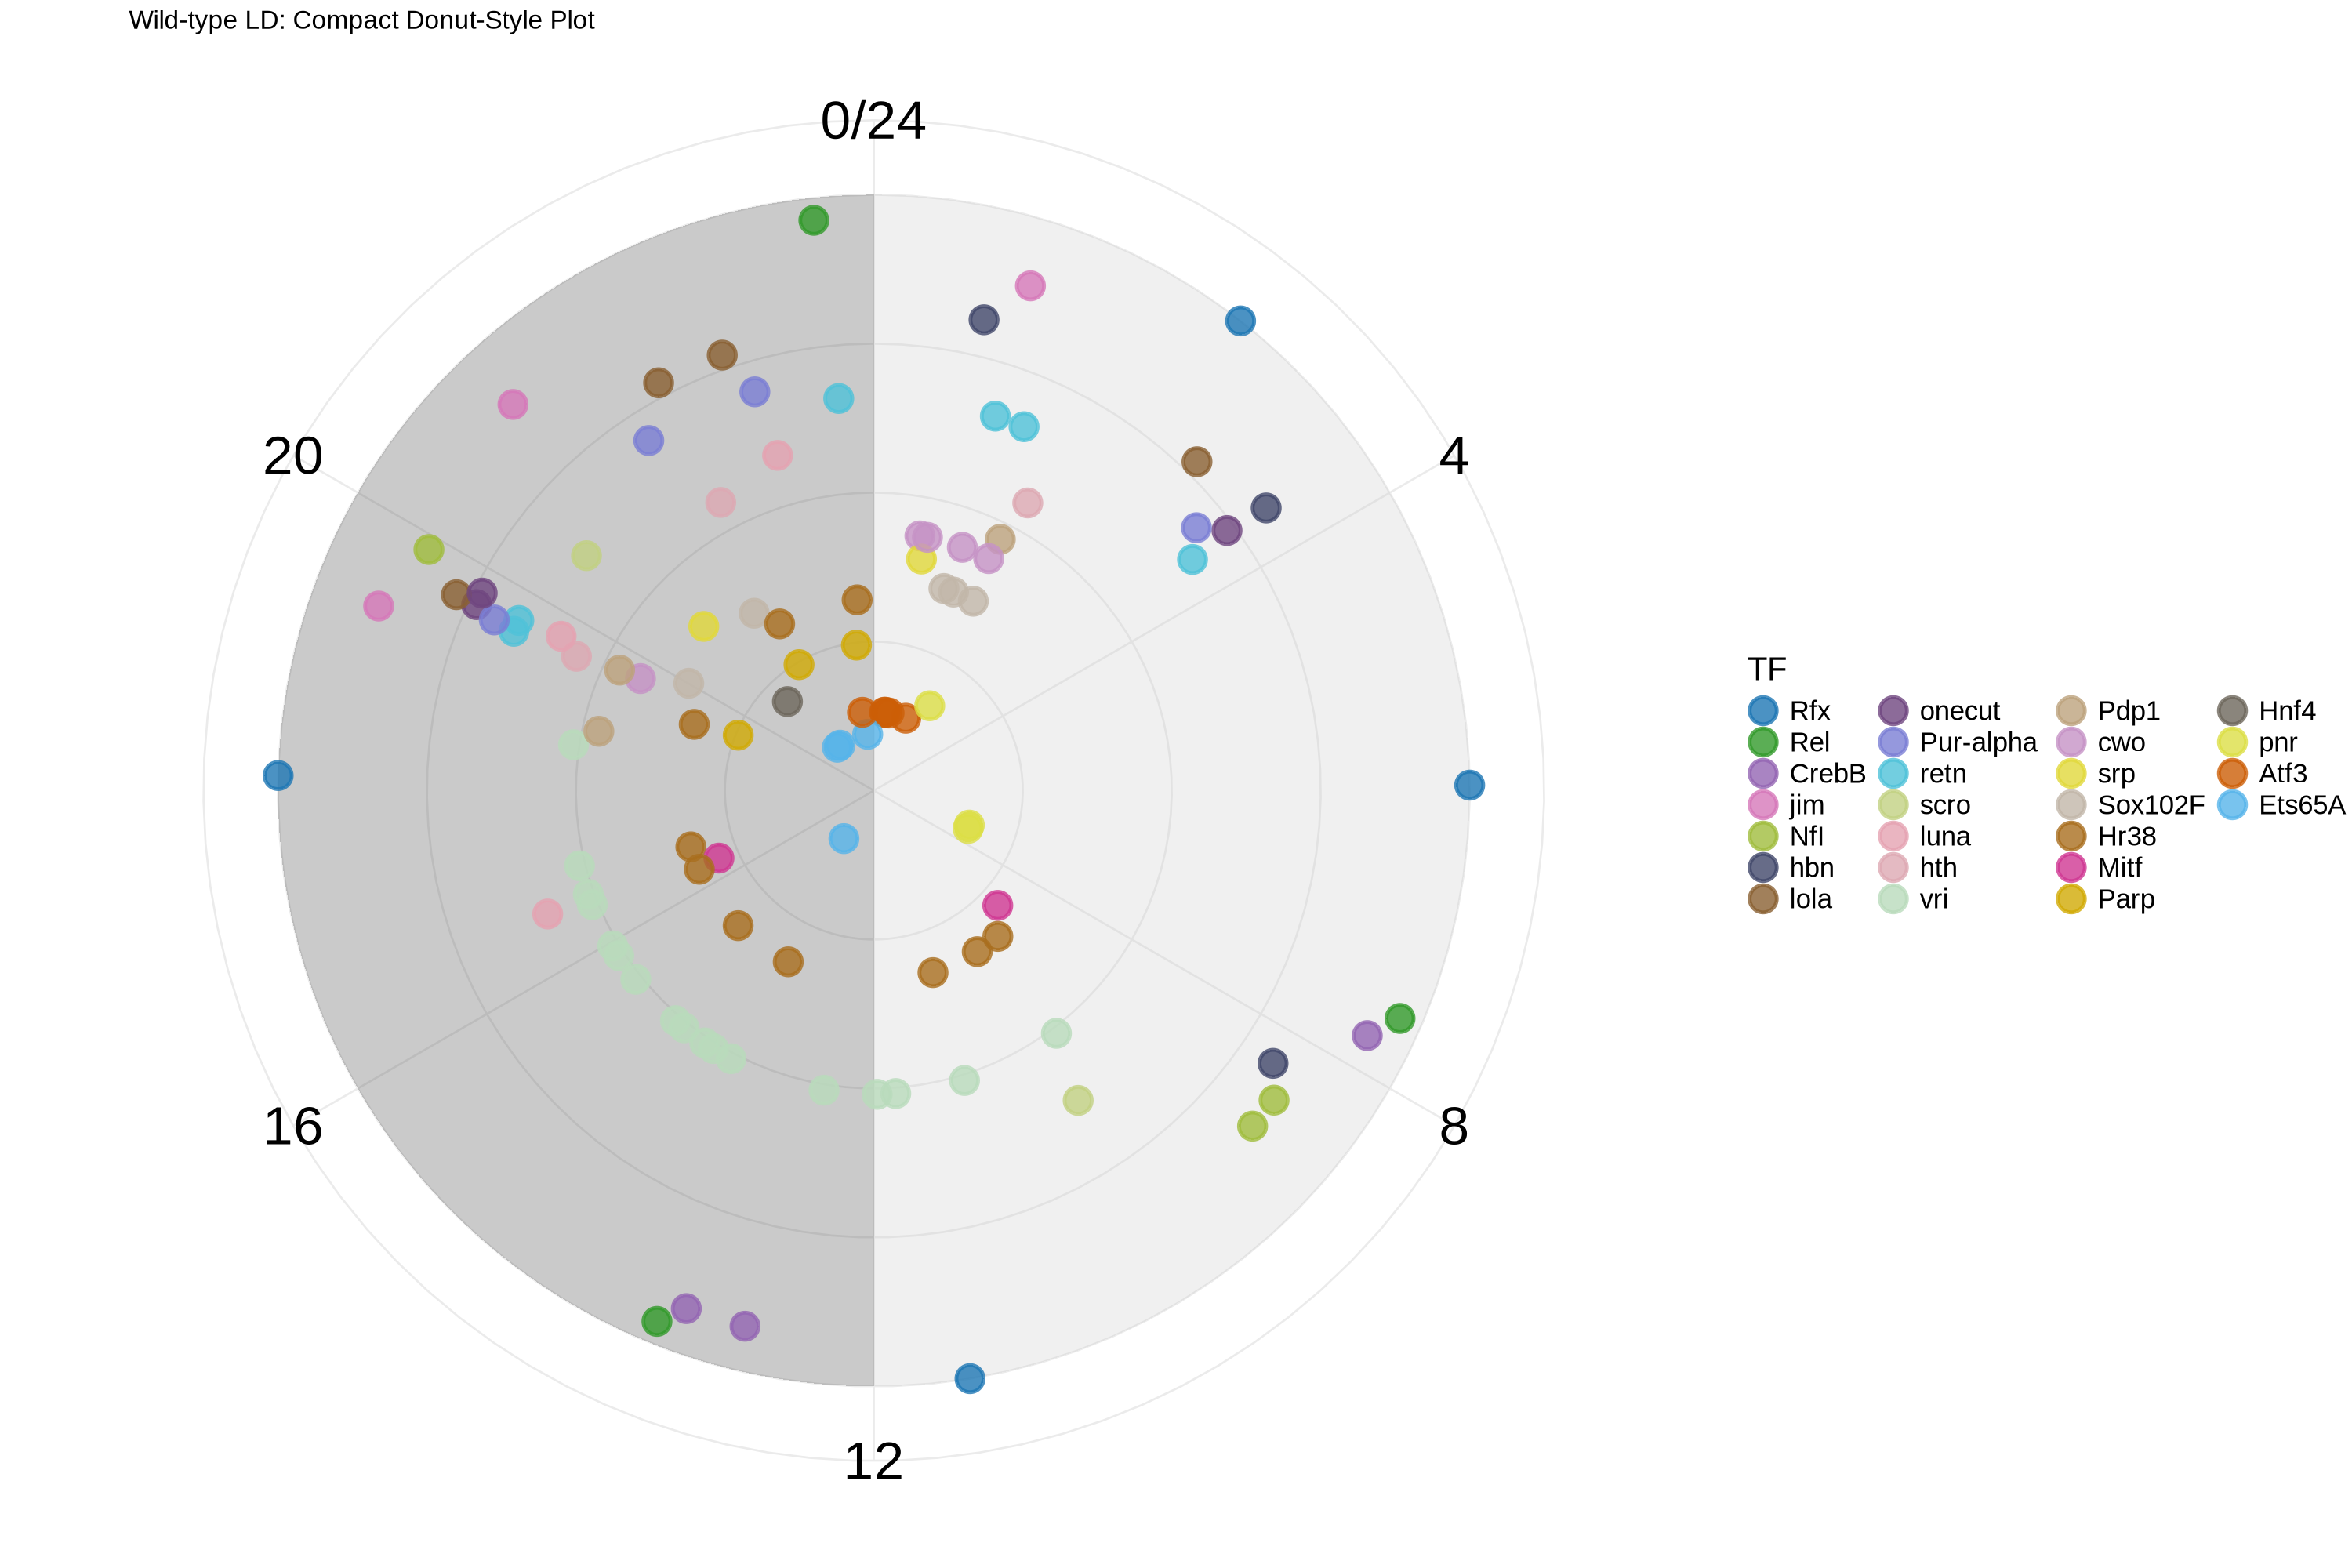

In [211]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c("CrebB"
             ,"Dr"
             ,"ken"
             ,"jim"
             ,"crp"
             ,"GATAd"
             ,"br"
             ,"REPTOR.BP"
             
             ,"NfI"
             ,"onecut"
             ,"Rfx"
             
             ,"klu"             
             ,"pnr"
             ,"CycT"
             ,"scro"
             ,"retn"
             ,"Sox102F"
             ,"Parp"
             ,"cwo"
             ,"srp"
             ,"luna"
             ,"Hr38"
             ,"Mitf"
             ,"Eip78C"
             ,"Hnf4"
             ,"vri"
             ,"Pur.alpha"
             ,"lola"
             ,"zfh2"
             ,"Pdp1"
             ,"kn"
             ,"vis"
             ,"Stat92E"
             ,"lbl"
             ,"pb"
             ,"Poxn"
             ,"grh"
             ,"hbn"
             ,"hth"
             ,"Nf.YA"
             ,"TFAM"
             ,"fd59A"
             ,"Atf3"
             ,"Blimp.1"
             ,"E.spl.m3.HLH"
             ,"eyg"
             ,"hb"
             ,"lbe"
             ,"run"
             ,"shn"
             ,"CG9727"
             ,"Doc2"
             ,"Hr78"
             ,"Sox100B"
             ,"bowl"
             ,"fru"   
             )


raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "E.spl.m3.HLH" = "E(spl)m3-HLH",
  "Blimp.1" = "Blimp-1",
  "Nf.YA"     = "Nf-YA",
  "Pur.alpha" = "Pur-alpha",
  "REPTOR.BP" = "REPTOR-BP"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "E.spl.m3.HLH" = "E(spl)m3-HLH",
    "Blimp.1" = "Blimp-1",
    "Nf.YA"     = "Nf-YA",
    "Pur.alpha" = "Pur-alpha",
    "REPTOR.BP" = "REPTOR-BP",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


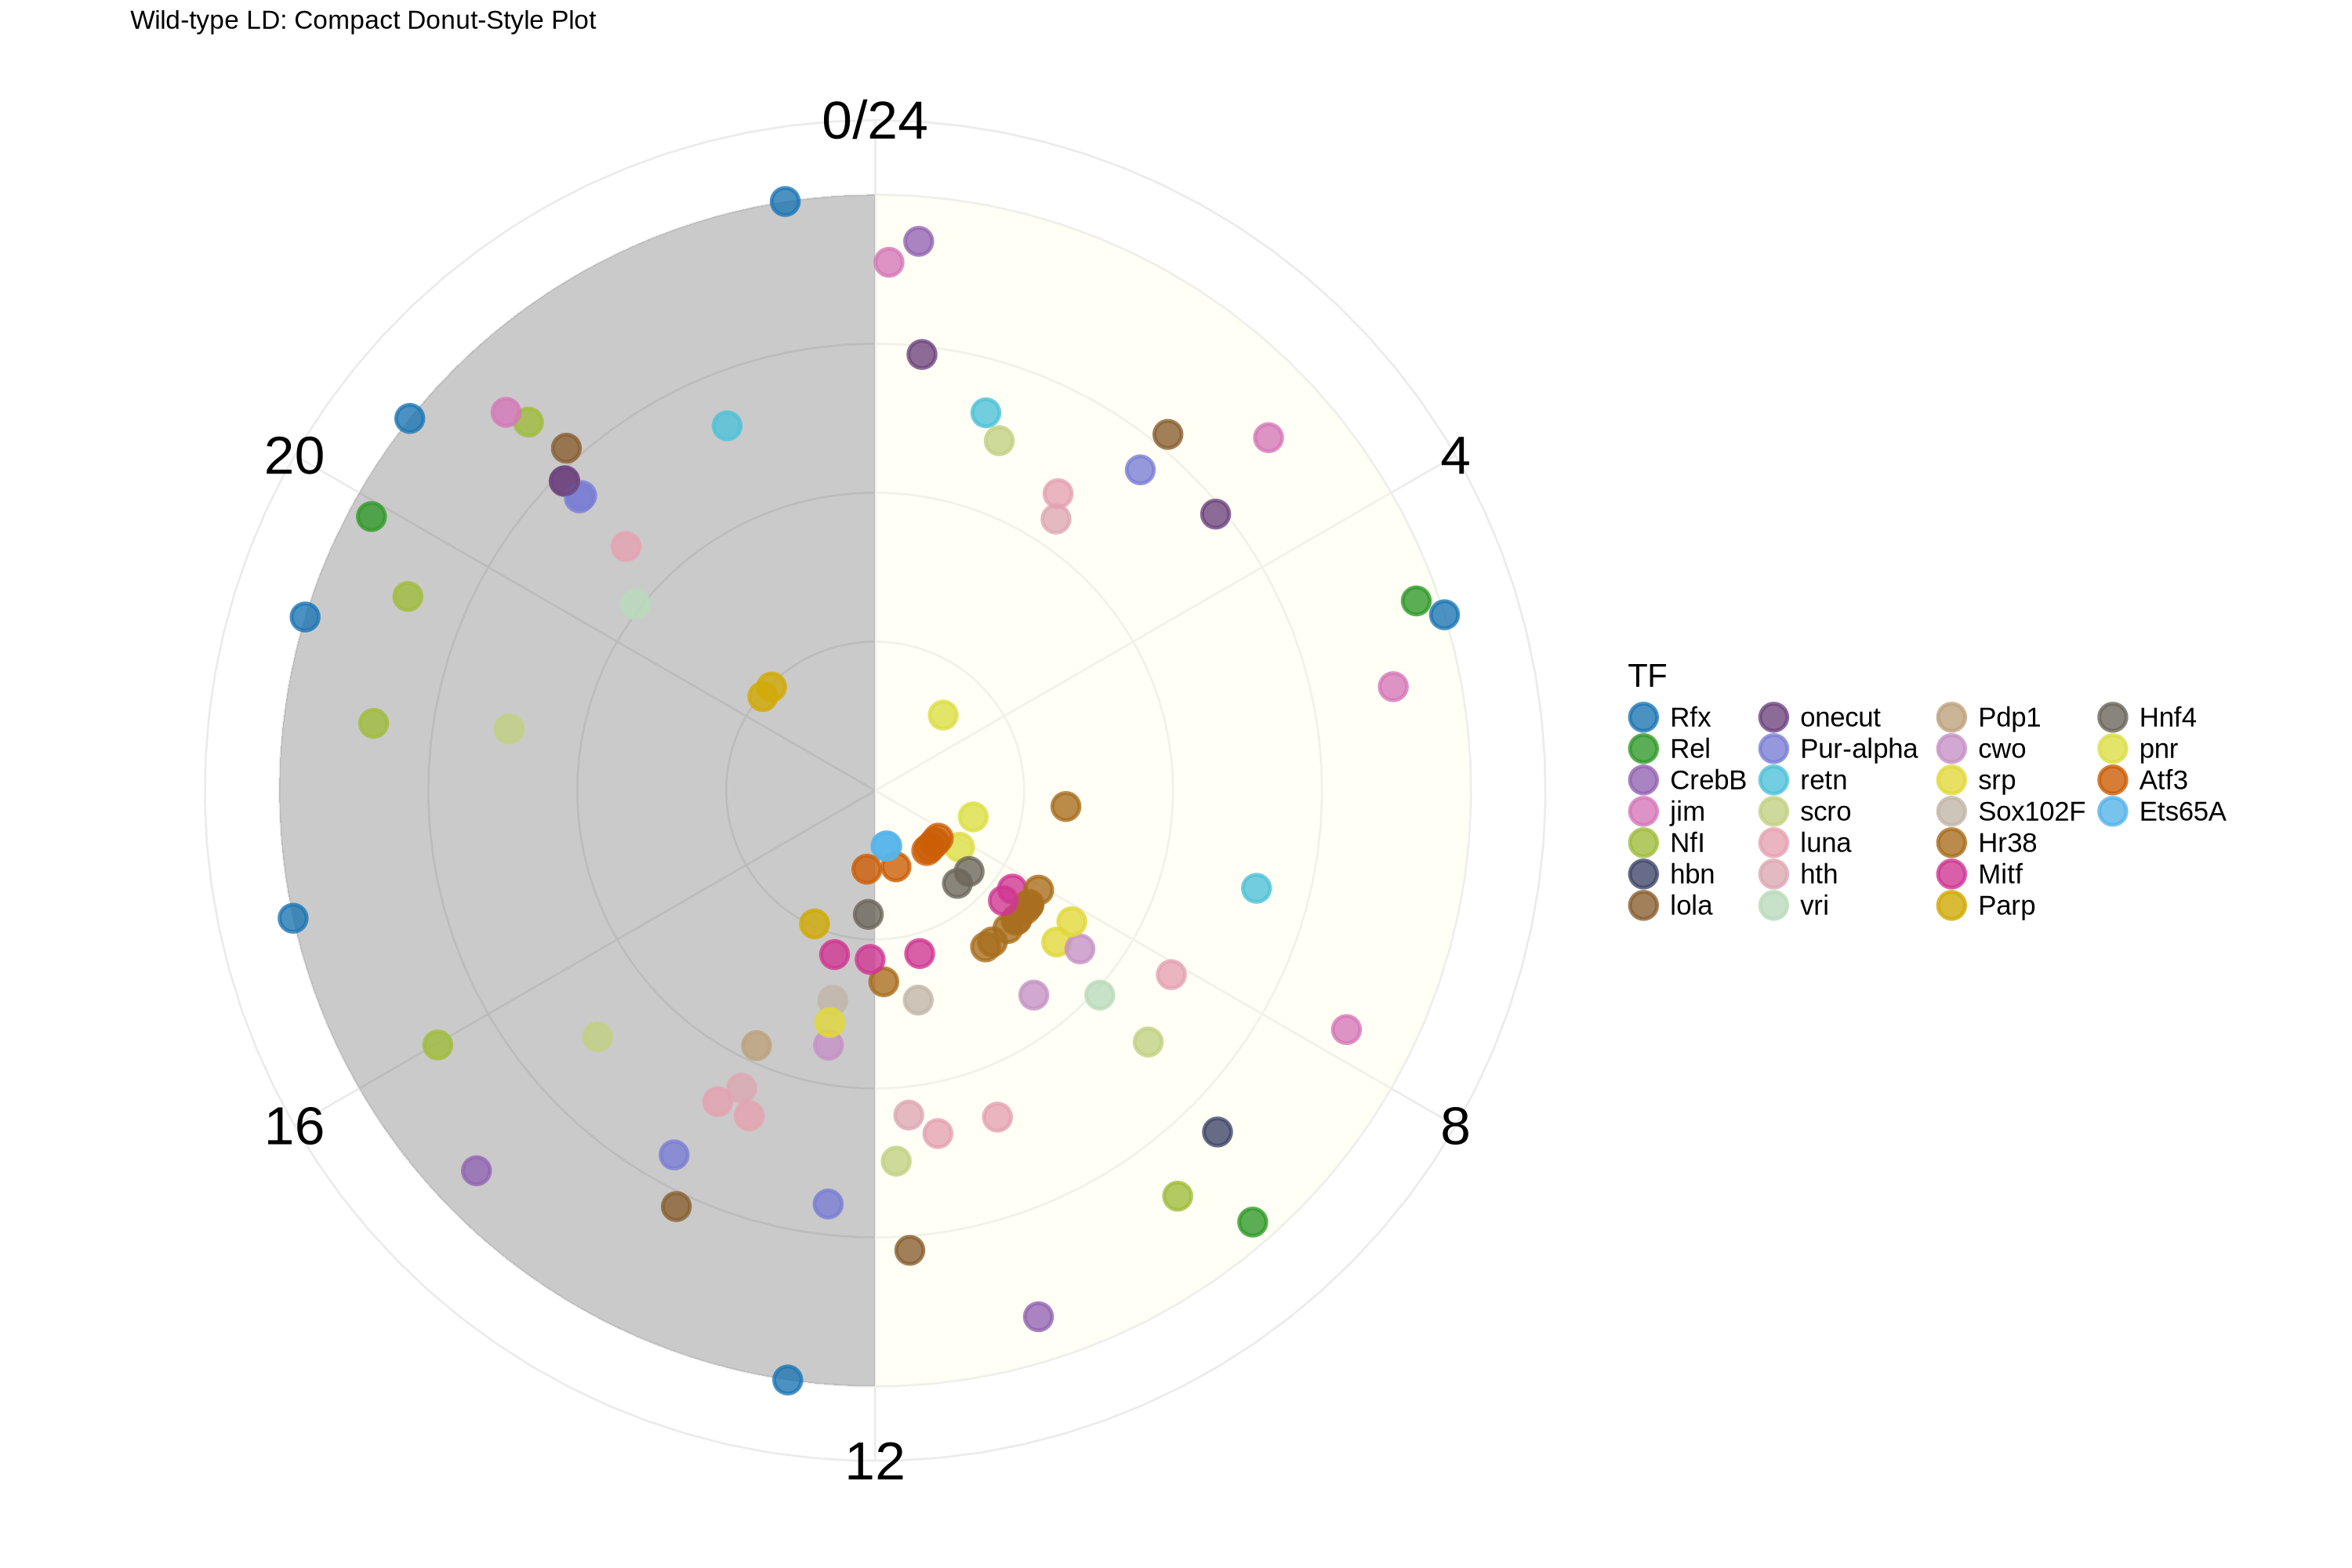

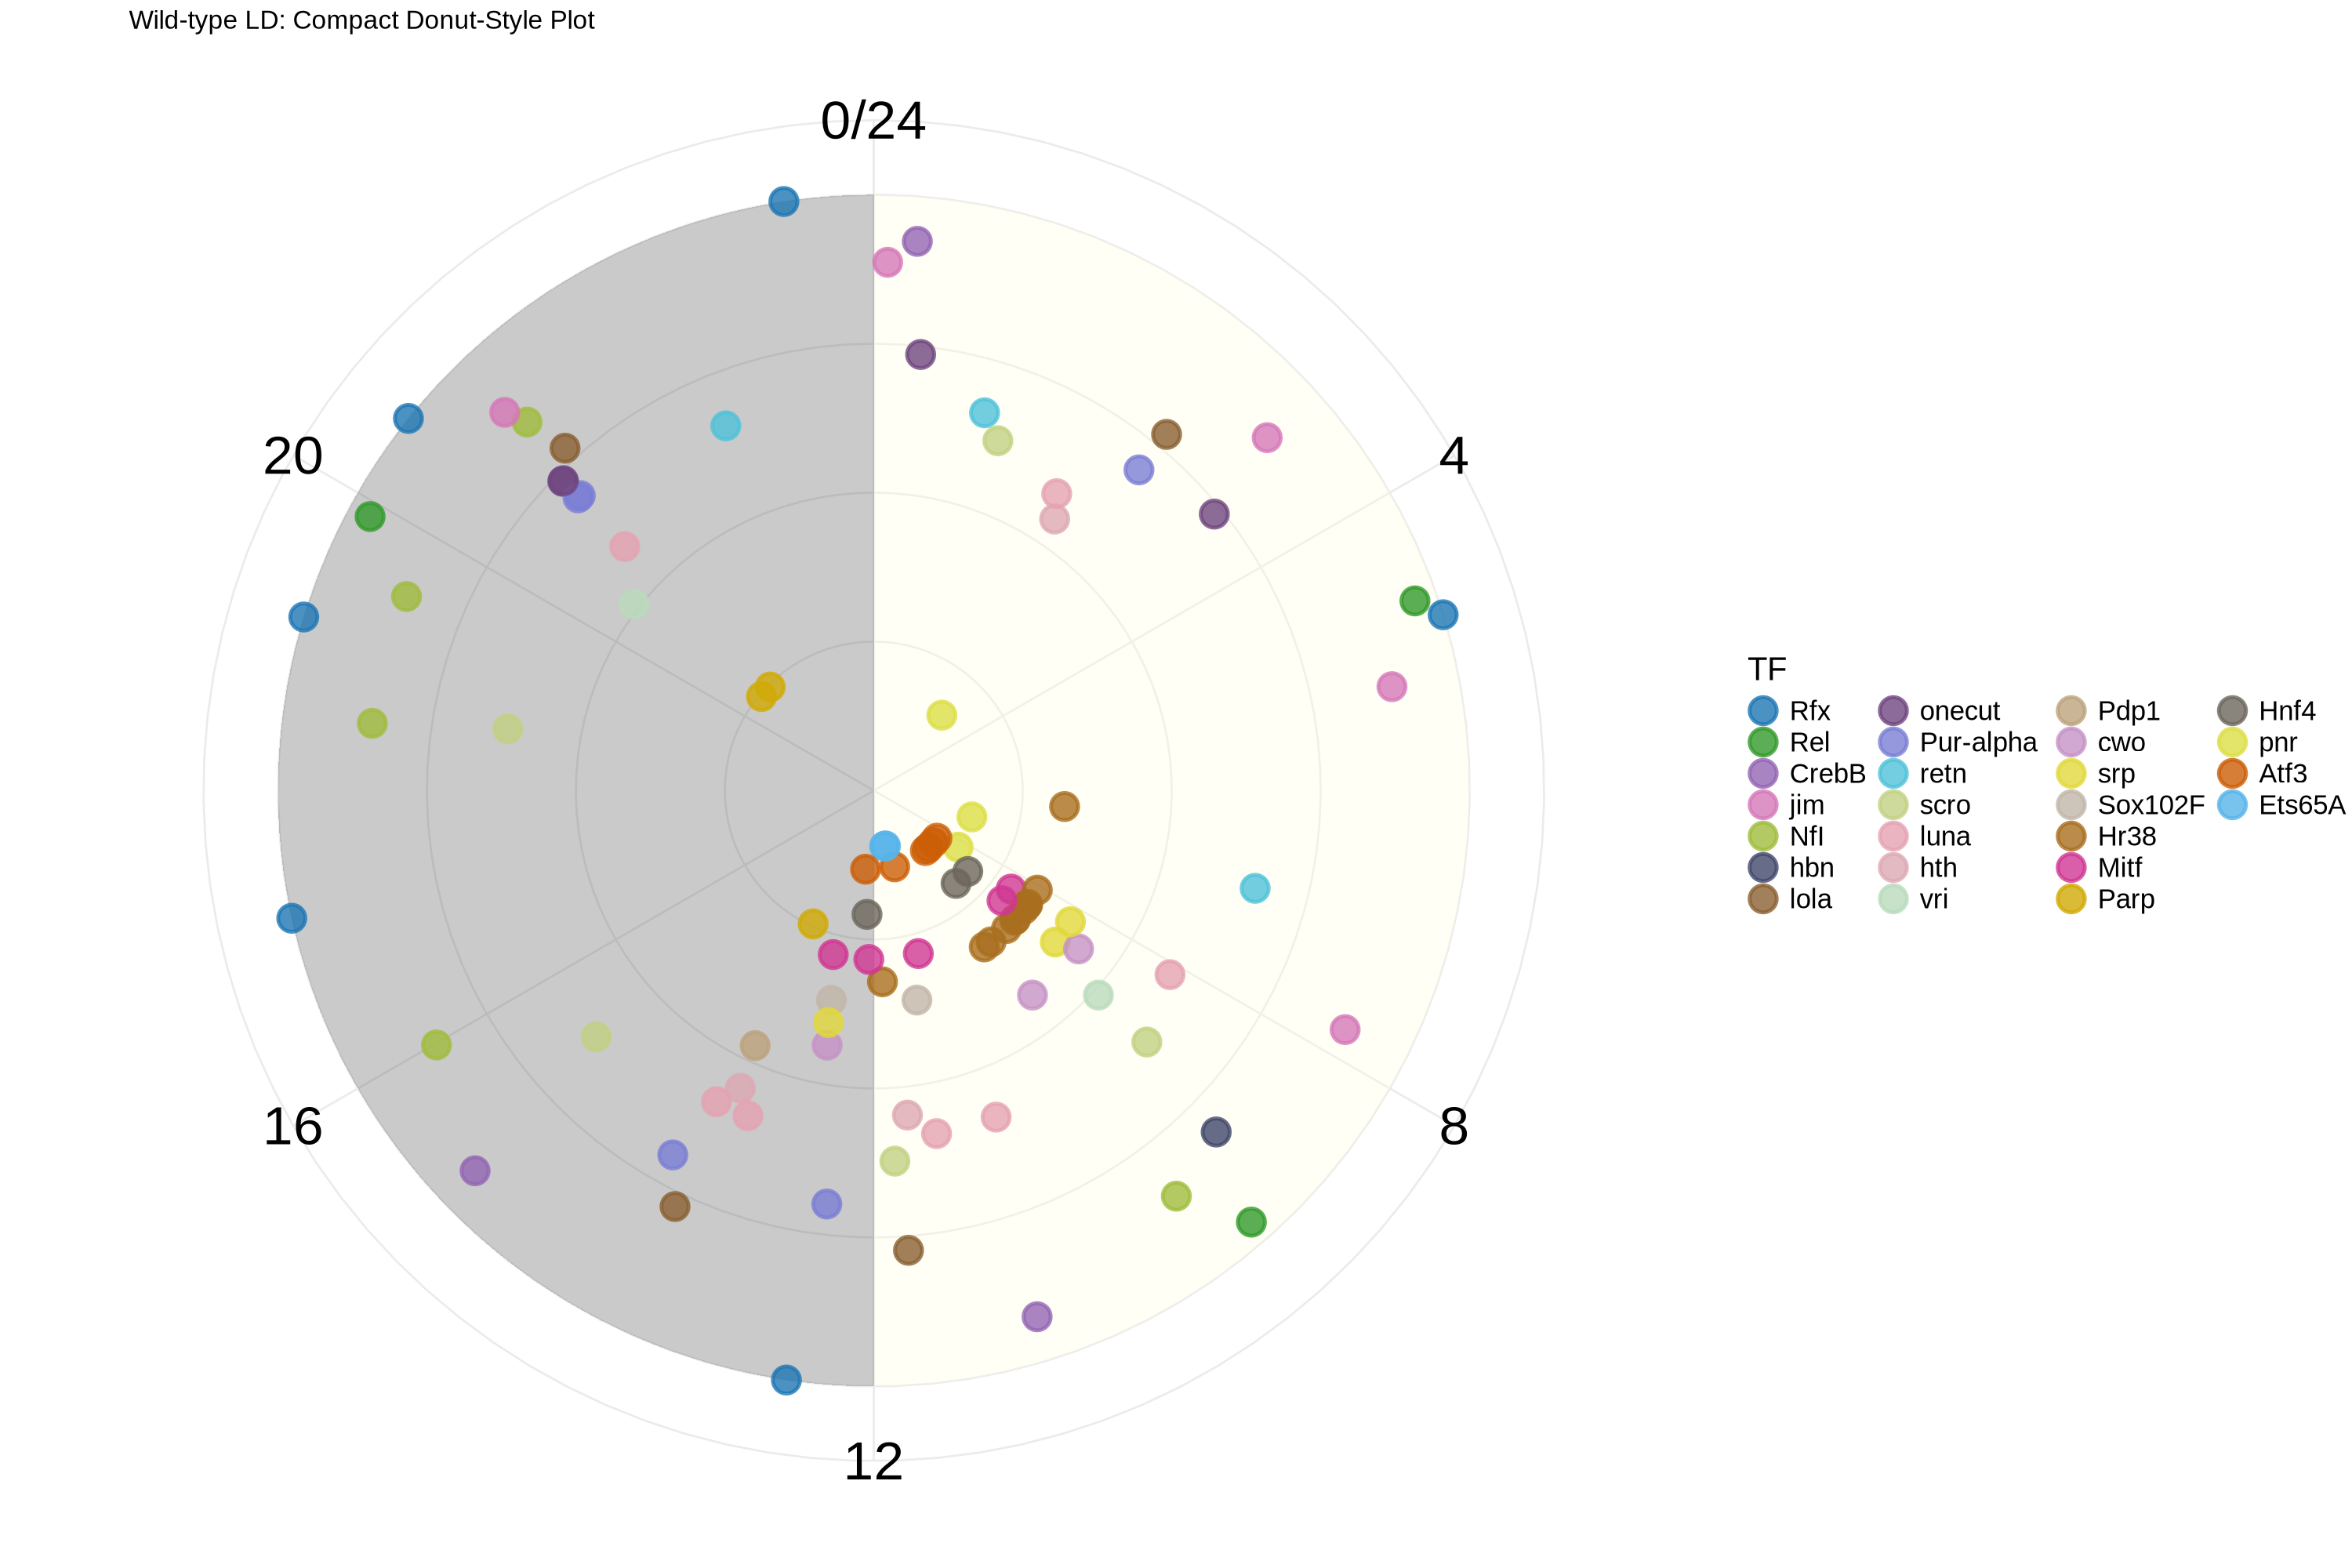

In [212]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c("CrebB"
             ,"Dr"
             ,"ken"
             ,"jim"
             ,"crp"
             ,"GATAd"
             ,"br"
             ,"REPTOR.BP"
             
             ,"NfI"
             ,"onecut"
             ,"Rfx"
             
             ,"klu"             
             ,"pnr"
             ,"CycT"
             ,"scro"
             ,"retn"
             ,"Sox102F"
             ,"Parp"
             ,"cwo"
             ,"srp"
             ,"luna"
             ,"Hr38"
             ,"Mitf"
             ,"Eip78C"
             ,"Hnf4"
             ,"vri"
             ,"Pur.alpha"
             ,"lola"
             ,"zfh2"
             ,"Pdp1"
             ,"kn"
             ,"vis"
             ,"Stat92E"
             ,"lbl"
             ,"pb"
             ,"Poxn"
             ,"grh"
             ,"hbn"
             ,"hth"
             ,"Nf.YA"

             ,"TFAM"
             ,"fd59A"
             ,"Atf3"
             ,"Blimp.1"
             ,"E.spl.m3.HLH"
             ,"eyg"
             ,"hb"
             ,"lbe"
             ,"run"
             ,"shn"
             ,"CG9727"
             ,"Doc2"
             ,"Hr78"
             ,"Sox100B"
             ,"bowl"
             ,"fru"   
             )


raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "E.spl.m3.HLH" = "E(spl)m3-HLH",
  "Blimp.1" = "Blimp-1",
  "Nf.YA"     = "Nf-YA",
  "Pur.alpha" = "Pur-alpha",
  "REPTOR.BP" = "REPTOR-BP"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "E.spl.m3.HLH" = "E(spl)m3-HLH",
    "Blimp.1" = "Blimp-1",
    "Nf.YA"     = "Nf-YA",
    "Pur.alpha" = "Pur-alpha",
    "REPTOR.BP" = "REPTOR-BP",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


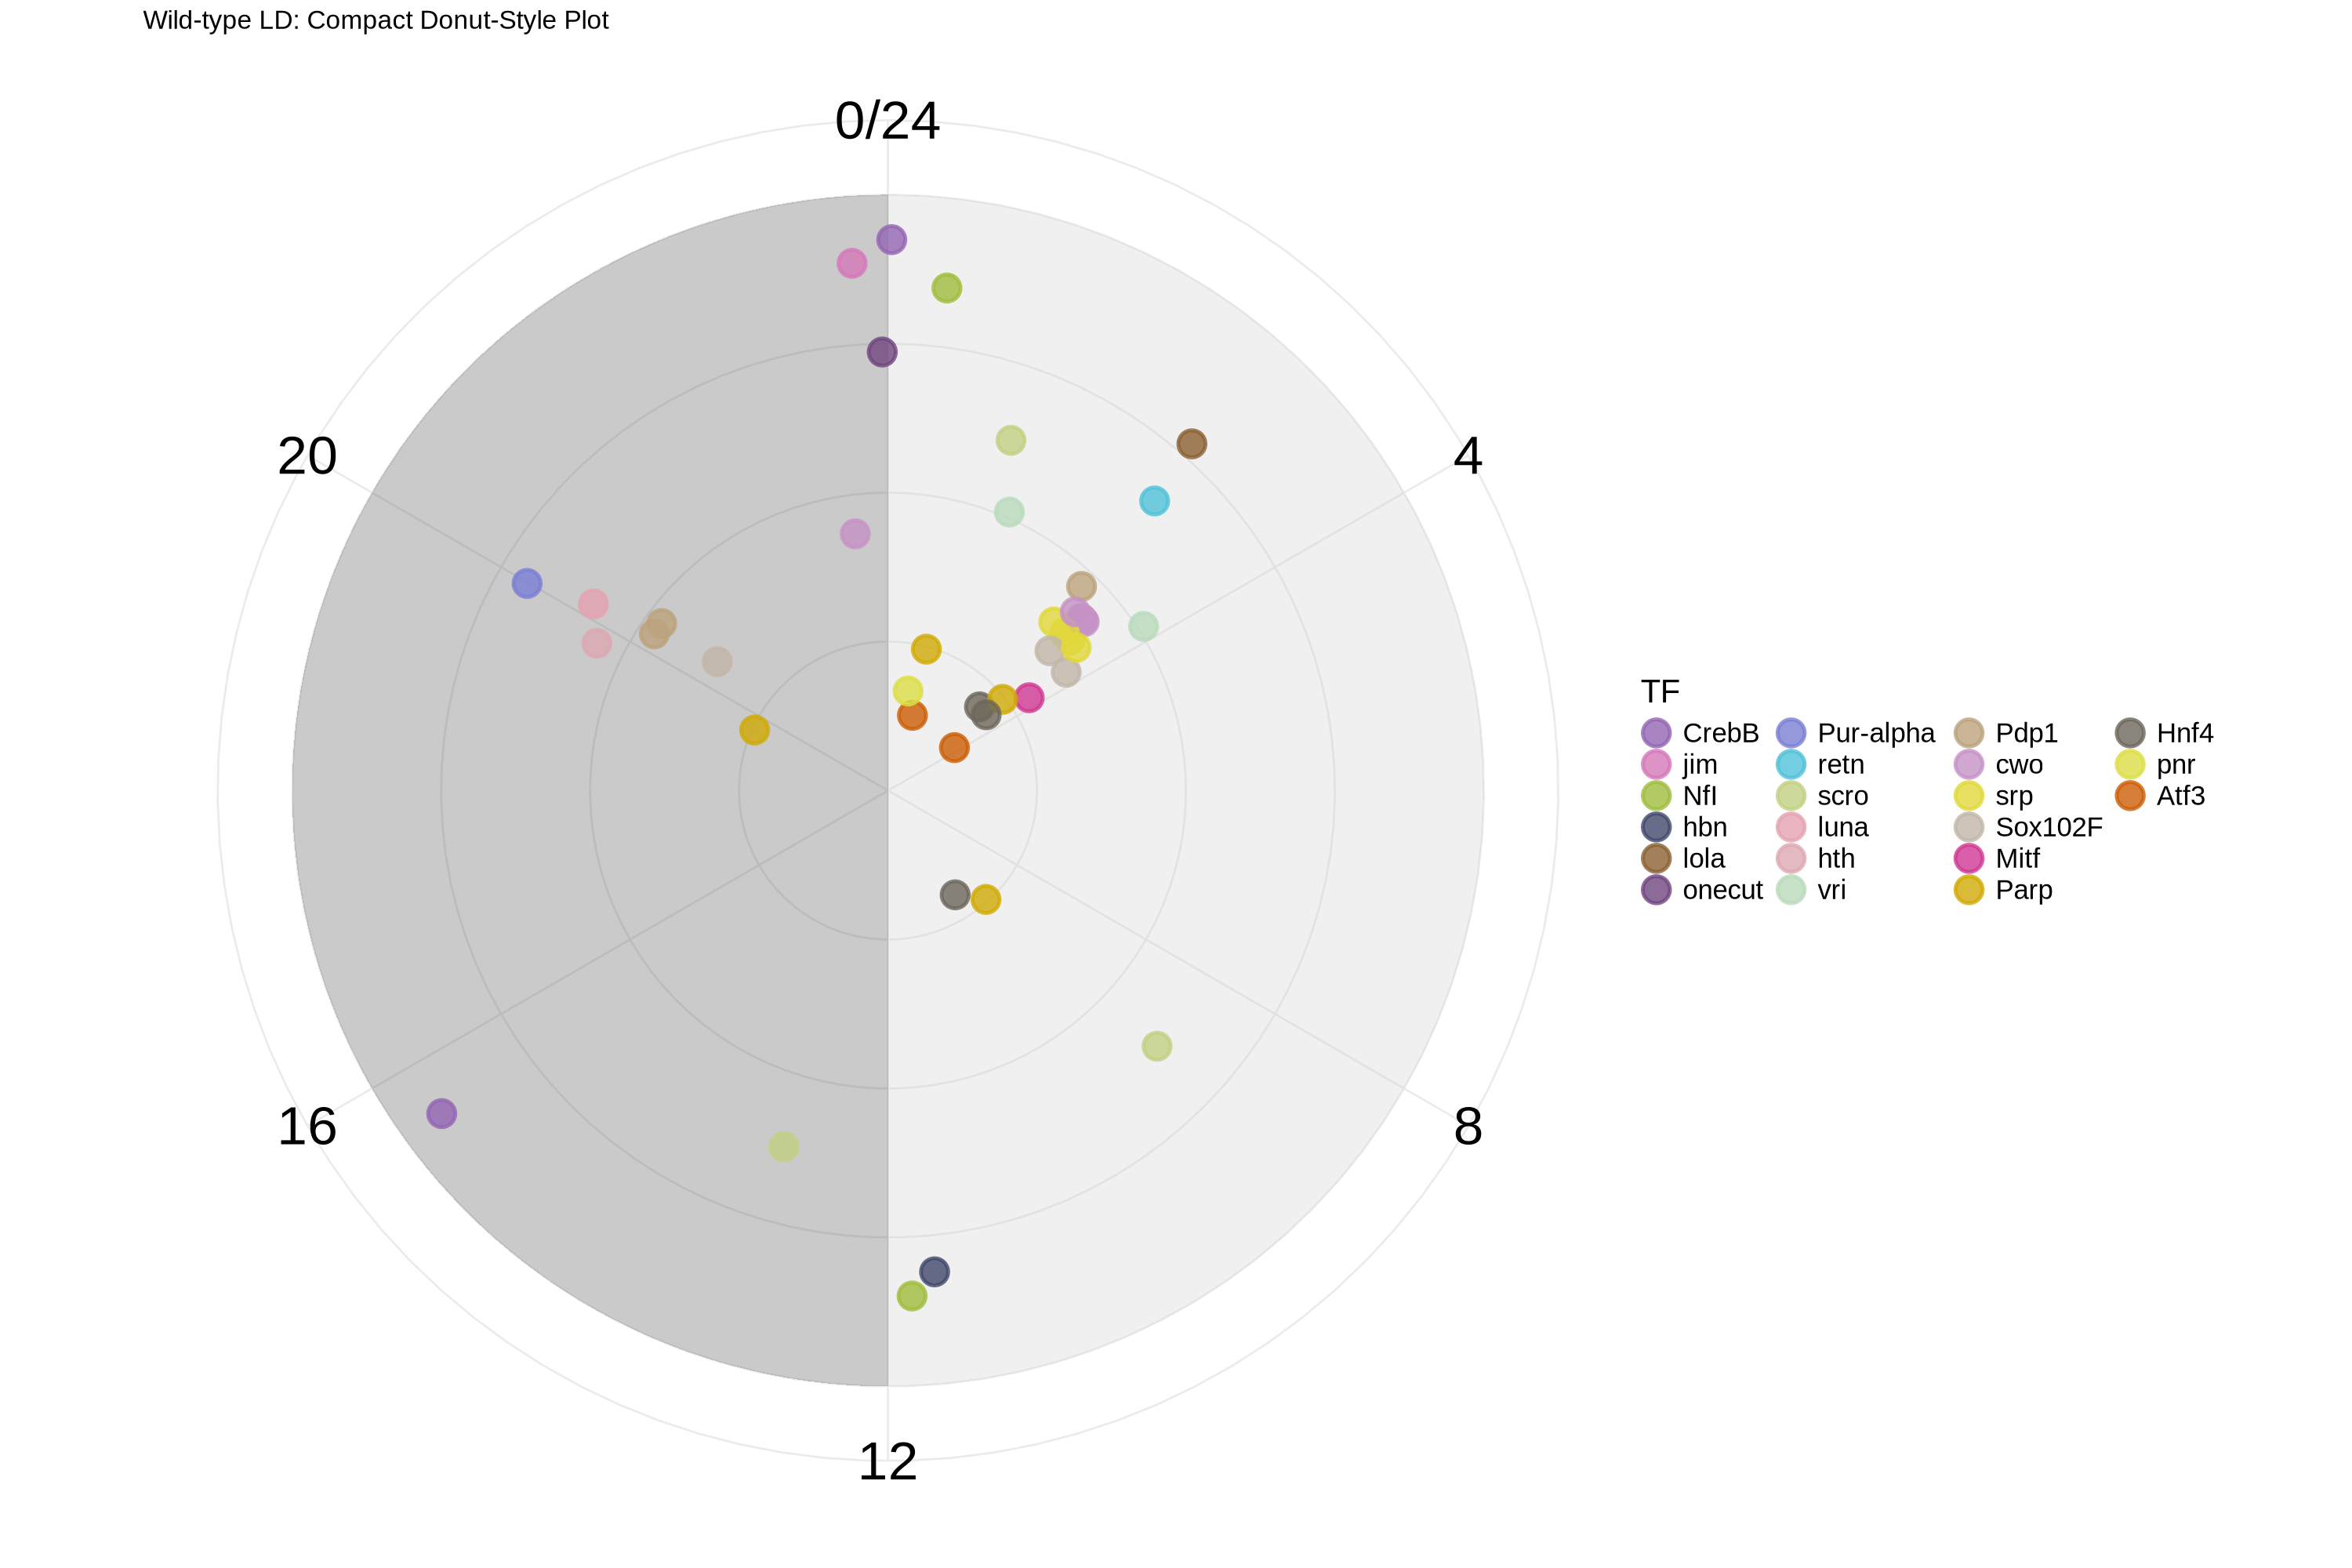

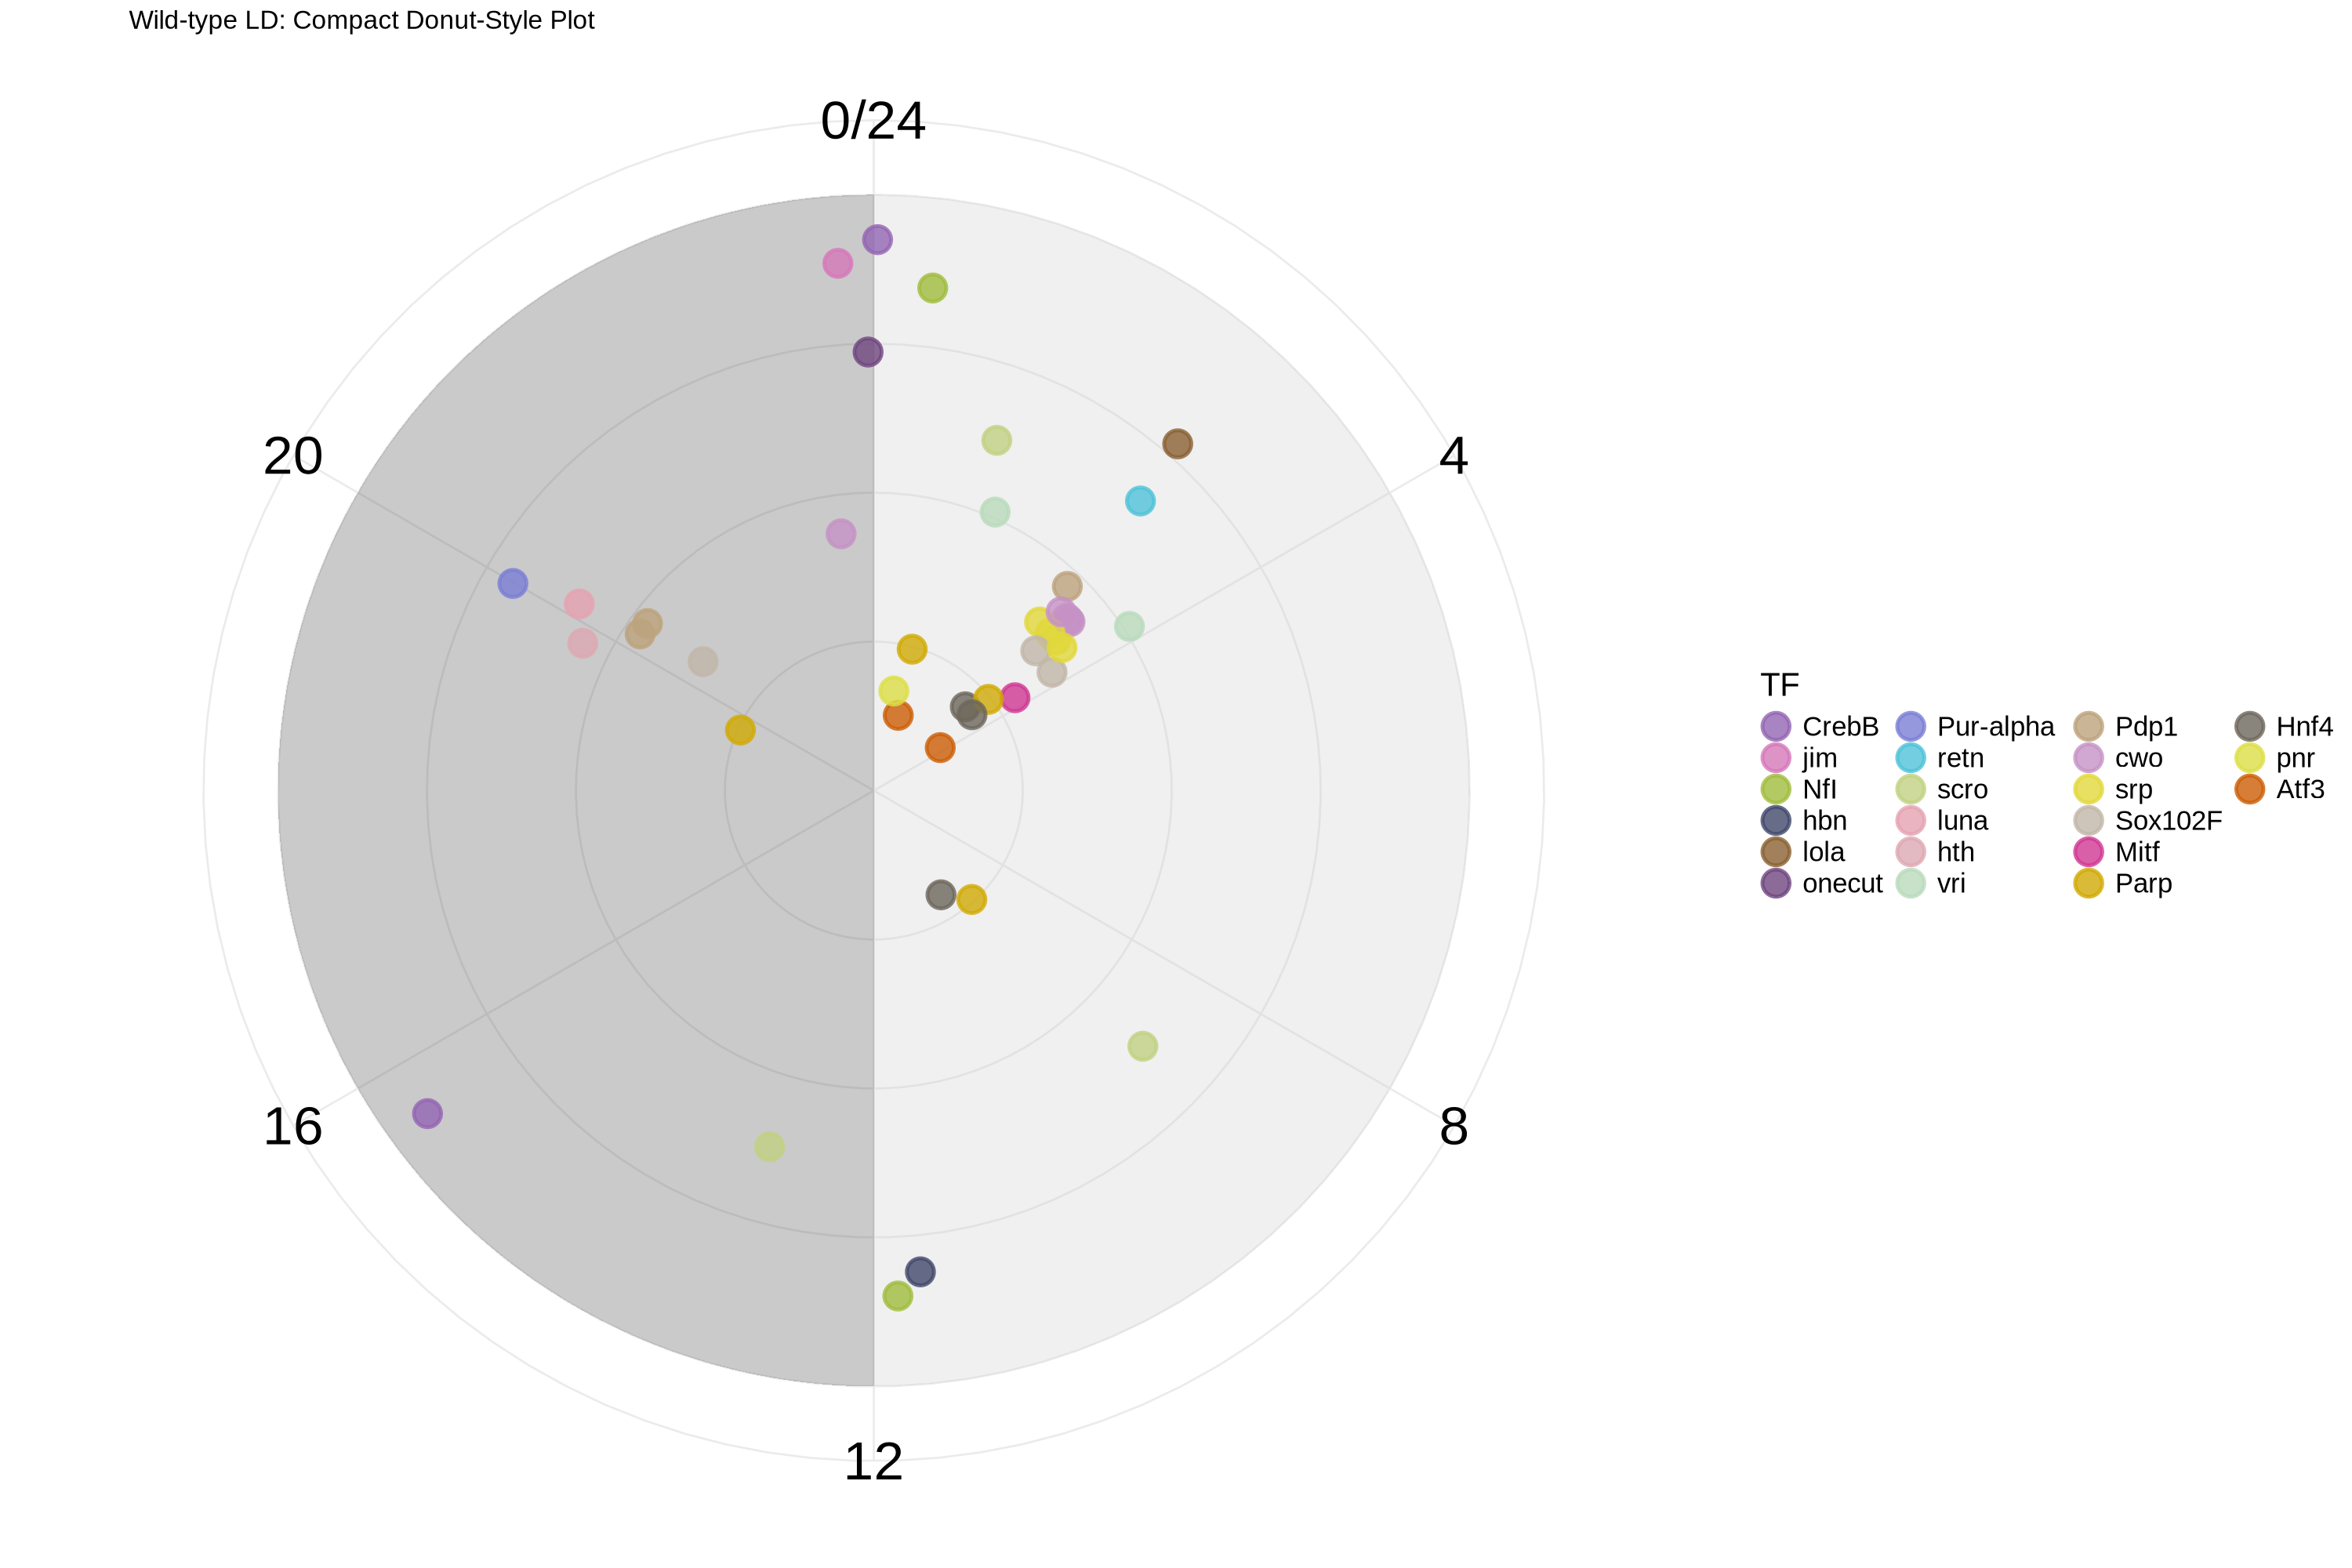

In [213]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c("CrebB"
             ,"Dr"
             ,"ken"
             ,"jim"
             ,"crp"
             ,"GATAd"
             ,"br"
             ,"REPTOR.BP"
             
             ,"NfI"
             ,"onecut"
             ,"Rfx"
             
             ,"klu"             
             ,"pnr"
             ,"CycT"
             ,"scro"
             ,"retn"
             ,"Sox102F"
             ,"Parp"
             ,"cwo"
             ,"srp"
             ,"luna"
             ,"Hr38"
             ,"Mitf"
             ,"Eip78C"
             ,"Hnf4"
             ,"vri"
             ,"Pur.alpha"
             ,"lola"
             ,"zfh2"
             ,"Pdp1"
             ,"kn"
             ,"vis"
             ,"Stat92E"
             ,"lbl"
             ,"pb"
             ,"Poxn"
             ,"grh"
             ,"hbn"
             ,"hth"
             ,"Nf.YA"
             ,"TFAM"
             ,"fd59A"
             ,"Atf3"
             ,"Blimp.1"
             ,"E.spl.m3.HLH"
             ,"eyg"
             ,"hb"
             ,"lbe"
             ,"run"
             ,"shn"
             ,"CG9727"
             ,"Doc2"
             ,"Hr78"
             ,"Sox100B"
             ,"bowl"
             ,"fru"   
             )


raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "E.spl.m3.HLH" = "E(spl)m3-HLH",
  "Blimp.1" = "Blimp-1",
  "Nf.YA"     = "Nf-YA",
  "Pur.alpha" = "Pur-alpha",
  "REPTOR.BP" = "REPTOR-BP"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "E.spl.m3.HLH" = "E(spl)m3-HLH",
    "Blimp.1" = "Blimp-1",
    "Nf.YA"     = "Nf-YA",
    "Pur.alpha" = "Pur-alpha",
    "REPTOR.BP" = "REPTOR-BP",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


In [71]:
sig_results[sig_results$CycID == "fru",]

CycID celltype genotype  light_condition p1           phase1    p2          
1  fru   DAN      Wild-type DD              7.875123e-04 18.699640 9.334355e-06
2  fru   Dm2      per0      DD              2.051379e-03 19.880022 6.011790e-07
3  fru   Dm3      Wild-type DD              6.590268e-02  2.031056 2.589697e-03
4  fru   Dm3      per0      LD              1.124775e-01 10.560112 2.112808e-02
5  fru   FAT-1    per0      LD              6.599124e-03 14.433587 2.196769e-03
6  fru   L1       Wild-type LD              7.330497e-03 12.642097 3.075838e-02
7  fru   L3       Wild-type LD              3.158589e-04 11.950657 1.932540e-03
8  fru   OCR      Wild-type LD              5.440911e-02 15.156940 6.225744e-03
9  fru   PAM-DAN  per0      DD              2.421115e-02 23.902679           NA
10 fru   PB       Wild-type DD              1.104171e-03 20.759162 7.795849e-03
11 fru   PGM      Wild-type LD              2.200951e-03  4.802855 7.997230e-03
12 fru   R1-6     Wild-type LD              2.543591e-05 18.564718 2.571998e-05
13 fru   R1-6     per0      LD              2.051067e-04 21.388703 4.080442e-04
14 fru   R7       Wild-type LD              3.970319e-02 16.515370 4.667707e-02
15 fru   T3       Wild-type LD              2.138761e-02 15.142756 1.098754e-01
16 fru   T4T5     Wild-type LD              1.061256e-03 17.069940 1.248980e-02
17 fru   T4T5ab   Wild-type LD              4.529569e-03 15.773651 4.523907e-03
18 fru   Tm20     per0      LD              8.550985e-03 12.373431 5.941979e-02
   phase2    p3           phase3    avg_p        avg_phase Condition   
1  19.566547 7.115287e-03 19.636927 2.637378e-03 19.301654 Wild-type DD
2  19.914679 1.998044e-03 20.174774 1.350008e-03 19.989807 per0 DD     
3   3.298701 6.731882e-02  3.526536 4.527040e-02  2.954216 Wild-type DD
4  13.017045 4.235695e-03 12.048945 4.594708e-02 11.878425 per0 LD     
5  15.242781 3.692566e-03 14.952444 4.162820e-03 14.876412 per0 LD     
6  12.018342 4.019065e-02 11.821061 2.609318e-02 12.160234 Wild-type LD
7  12.016032 8.948799e-04 12.474551 1.047760e-03 12.146984 Wild-type LD
8  15.330642 2.251519e-02 15.322970 2.771668e-02 15.270188 Wild-type LD
9         NA 4.524789e-03 23.401486 1.436797e-02 23.652082 per0 DD     
10 20.809630 1.627411e-02 21.299849 8.391376e-03 20.956100 Wild-type DD
11  4.278719 2.631060e-03  4.856081 4.276414e-03  4.646024 Wild-type LD
12 18.474309 1.149463e-05 18.421180 2.088351e-05 18.486735 Wild-type LD
13 21.437079 1.975217e-04 20.854393 2.702242e-04 21.226870 per0 LD     
14 16.590523 3.249321e-02 16.503813 3.962449e-02 16.536568 Wild-type LD
15 16.168898 1.618621e-02 16.252922 4.914974e-02 15.855882 Wild-type LD
16 17.414583 8.606590e-03 17.055097 7.385881e-03 17.179836 Wild-type LD
17 15.697560 6.009057e-03 15.765787 5.020844e-03 15.745666 Wild-type LD
18 12.338354 1.946149e-02 12.701510 2.914409e-02 12.471064 per0 LD

## females

In [ ]:
# merge_and_plot_MetaCycle_results.R
# This script merges three MetaCycle output runs, computes average p-values and circular mean phases,
# and visualizes rhythmic TF activity across cell types and conditions.

# 1) Load required libraries
library(dplyr)
library(tidyr)
library(ggplot2)

# 2) Read the three MetaCycle result files
combined_1 <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/all_MetaCycle_TF_rhythmicity_F_1.csv", stringsAsFactors = FALSE)
combined_2 <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/all_MetaCycle_TF_rhythmicity_F_2.csv", stringsAsFactors = FALSE)
combined_3 <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/all_MetaCycle_TF_rhythmicity_F_3.csv", stringsAsFactors = FALSE)

# 3) Define circular mean function for phase (0–24 h)
circ_mean_hours <- function(phases) {
  radians <- phases/24 * 2 * pi
  mean_angle <- atan2(mean(sin(radians), na.rm=TRUE), mean(cos(radians), na.rm=TRUE))
  mean_hour <- (mean_angle %% (2*pi)) / (2*pi) * 24
  return(mean_hour)
}

# 4) Merge datasets on identifiers
id_cols <- c("CycID", "celltype", "genotype", "light_condition")
merged <- combined_1 %>%
  select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
  rename(p1 = meta2d_pvalue, phase1 = meta2d_phase) %>%
  inner_join(
    combined_2 %>% select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
      rename(p2 = meta2d_pvalue, phase2 = meta2d_phase),
    by = id_cols
  ) %>%
  inner_join(
    combined_3 %>% select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
      rename(p3 = meta2d_pvalue, phase3 = meta2d_phase),
    by = id_cols
  )

# 5) Compute average p-value and phase
merged <- merged %>%
  rowwise() %>%
  mutate(
    avg_p = mean(c(p1, p2, p3), na.rm = TRUE),
    avg_phase = circ_mean_hours(c(phase1, phase2, phase3))
  ) %>%
  ungroup()
# Filter out rows with NA in any of the three p-values
merged <- merged %>%
  filter(!is.na(p1) & !is.na(p2) & !is.na(p3))

# 6) Save merged averaged results
write.csv(merged, "TF_rhythmicity_avg_F.csv", row.names = FALSE)

# 7) Plot rhythmic TFs for each cell type and condition
sig_results <- merged %>%
  filter(avg_p < 0.05) %>%
  arrange(celltype, CycID)

sig_results$celltype <- factor(sig_results$celltype, levels = unique(sig_results$celltype))
sig_results$CycID    <- factor(sig_results$CycID, levels = unique(sig_results$CycID))

sig_results <- sig_results %>%
  mutate(Condition = paste(genotype, light_condition))

p <- ggplot(sig_results, aes(x = CycID, y = celltype,
                             color = avg_phase, size = -log10(avg_p))) +
  geom_point(alpha = 0.8) +
  scale_color_gradient(low = "yellow", high = "blue4", name = "Phase (hrs)") +
  scale_size(range = c(1, 4), name = "-log10(avg p-value)") +
  facet_wrap(~ Condition, scales = "free_y") +
  theme_minimal(base_size = 8) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
    strip.text = element_text(size = 8)
  ) +
  labs(
    title = "Rhythmic TF Activity Across Cell Types and Conditions",
    x = "Transcription Factor",
    y = "Cell Type"
  )

print(p)


In [ ]:
options(repr.plot.width = 20,
        repr.plot.height = 25,
        repr.plot.res    = 500)
   # resolution in DPI

# Make background white
par(bg = "white")


In [ ]:
# 7) Define cyclic color palette
phase_colors <- hsv(seq(0, 1, length.out = 100), 1, 1)

# on your averaged tibble
sig_results$Condition <- factor(
  paste(sig_results$genotype, sig_results$light_condition),
  levels = c("Wild-type LD", "Wild-type DD", "per0 LD", "per0 DD")
)

# 8) Plot rhythmic TFs with cyclic phase scale
p <- ggplot(sig_results, aes(x = celltype, y = CycID,
                             color = avg_phase, size = -log10(avg_p))) +
  geom_point(alpha = 0.8) +
  scale_color_gradientn(
    colors = phase_colors,
    limits = c(0, 24),
    breaks = c(0, 6, 12, 18, 24),
    name = "Phase (hrs)"
  ) +
  scale_size(range = c(1, 4), name = "-log10(avg p-value)") +
  facet_wrap(~ Condition, scales = "free_y") +
  theme_minimal(base_size = 6) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
    strip.text   = element_text(size = 8)
  ) +
  labs(
    title = "Rhythmic TF Activity Across Cell Types and Conditions",
    x = "Transcription Factor",
    y = "Cell Type"
  )

print(p)

In [25]:
options(repr.plot.width = 6,
        repr.plot.height = 4,
        repr.plot.res    = 500)
   # resolution in DPI

# Make background white
par(bg = "white")


In [26]:
library(stringr)

sig_results <- sig_results %>%
  mutate(CycID = str_remove(CycID, "\\.{3}$"))


library(dplyr)
  #filter(genotype == "Wild-type", light == "LD")

# Count how many unique rhythmic TF activities were detected in WT DD
n_rhythmic <- sig_results %>% pull(CycID) %>% unique() %>% length()
cat("Total number of rhythmic TF activities detected:", n_rhythmic, "\n")

# For each TF, count the number of unique cell types in which it appears
tf_abundance <- sig_results %>%
  group_by(CycID) %>%
  summarize(num_celltypes = n_distinct(celltype), .groups = "drop") %>%
  arrange(desc(num_celltypes))

# Get the top 17 TFs that are most abundant (detected in the highest number of cell types)
top_20_tf <- tf_abundance %>% slice_head(n = 54)

# Display the top 17 TFs
print(top_20_tf)


Total number of rhythmic TF activities detected: 217 
# A tibble: 54 × 2
   CycID     num_celltypes
   <chr>             <int>
 1 lola                 44
 2 jumu                 41
 3 srp                  41
 4 NfI                  40
 5 Sox102F              39
 6 CG5641               37
 7 cwo                  37
 8 Pdp1                 36
 9 Pur.alpha            35
10 gce                  34
# ℹ 44 more rows


In [166]:
print(top_20_tf$CycID)

 [1] "lola"      "jumu"      "srp"       "NfI"       "Sox102F"   "CG5641"   
 [7] "cwo"       "Pdp1"      "Pur.alpha" "gce"       "mid"       "Hesr"     
[13] "nej"       "jim"       "kay"       "onecut"    "Hnf4"      "NK7.1"    
[19] "hth"       "Hr38"      "Sox14"     "luna"      "svp"       "Deaf1"    
[25] "Met"       "Parp"      "gl"        "Hsf"       "SoxN"      "retn"     
[31] "scro"      "vri"       "pho"       "sage"      "Rel"       "dve"      
[37] "tai"       "Atf3"      "Ets96B"    "Fer1"      "CG12605"   "Dif"      
[43] "Rfx"       "TfAP.2"    "B.H2"      "CrebB"     "Mef2"      "Mitf"     
[49] "ey"        "hbn"       "pnr"       "repo"      "EcR"       "Ets65A"   


## shared

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


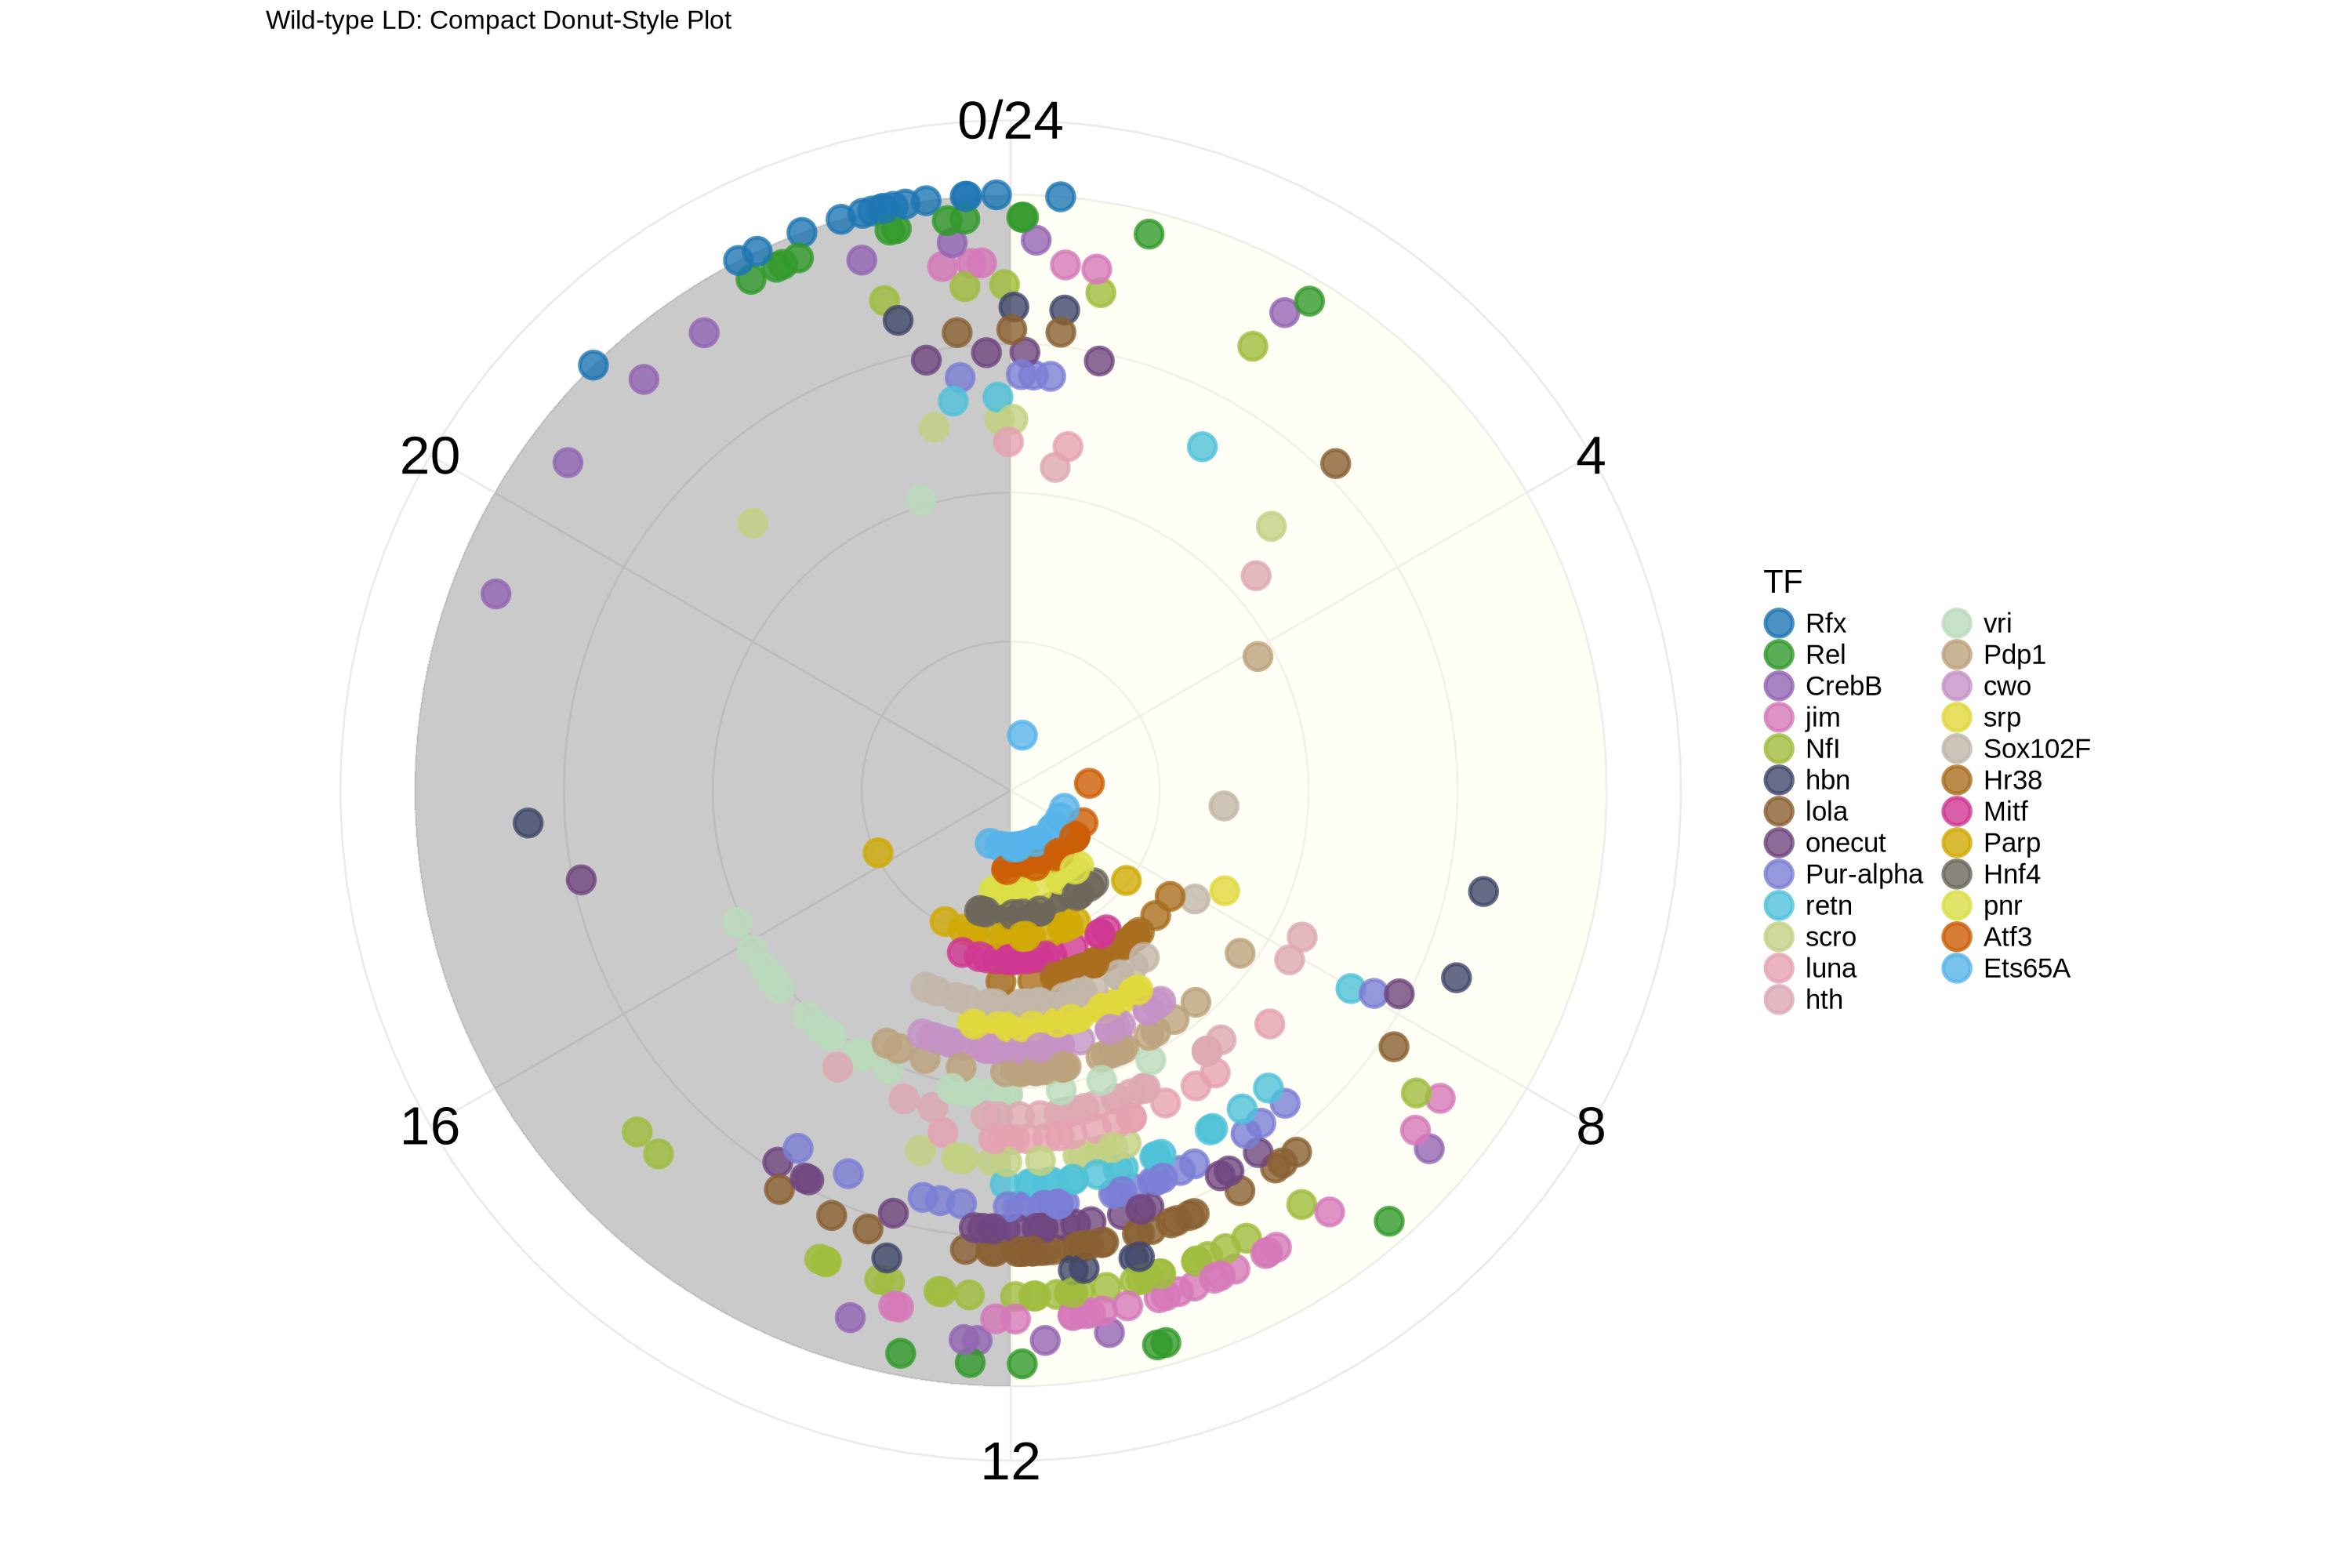

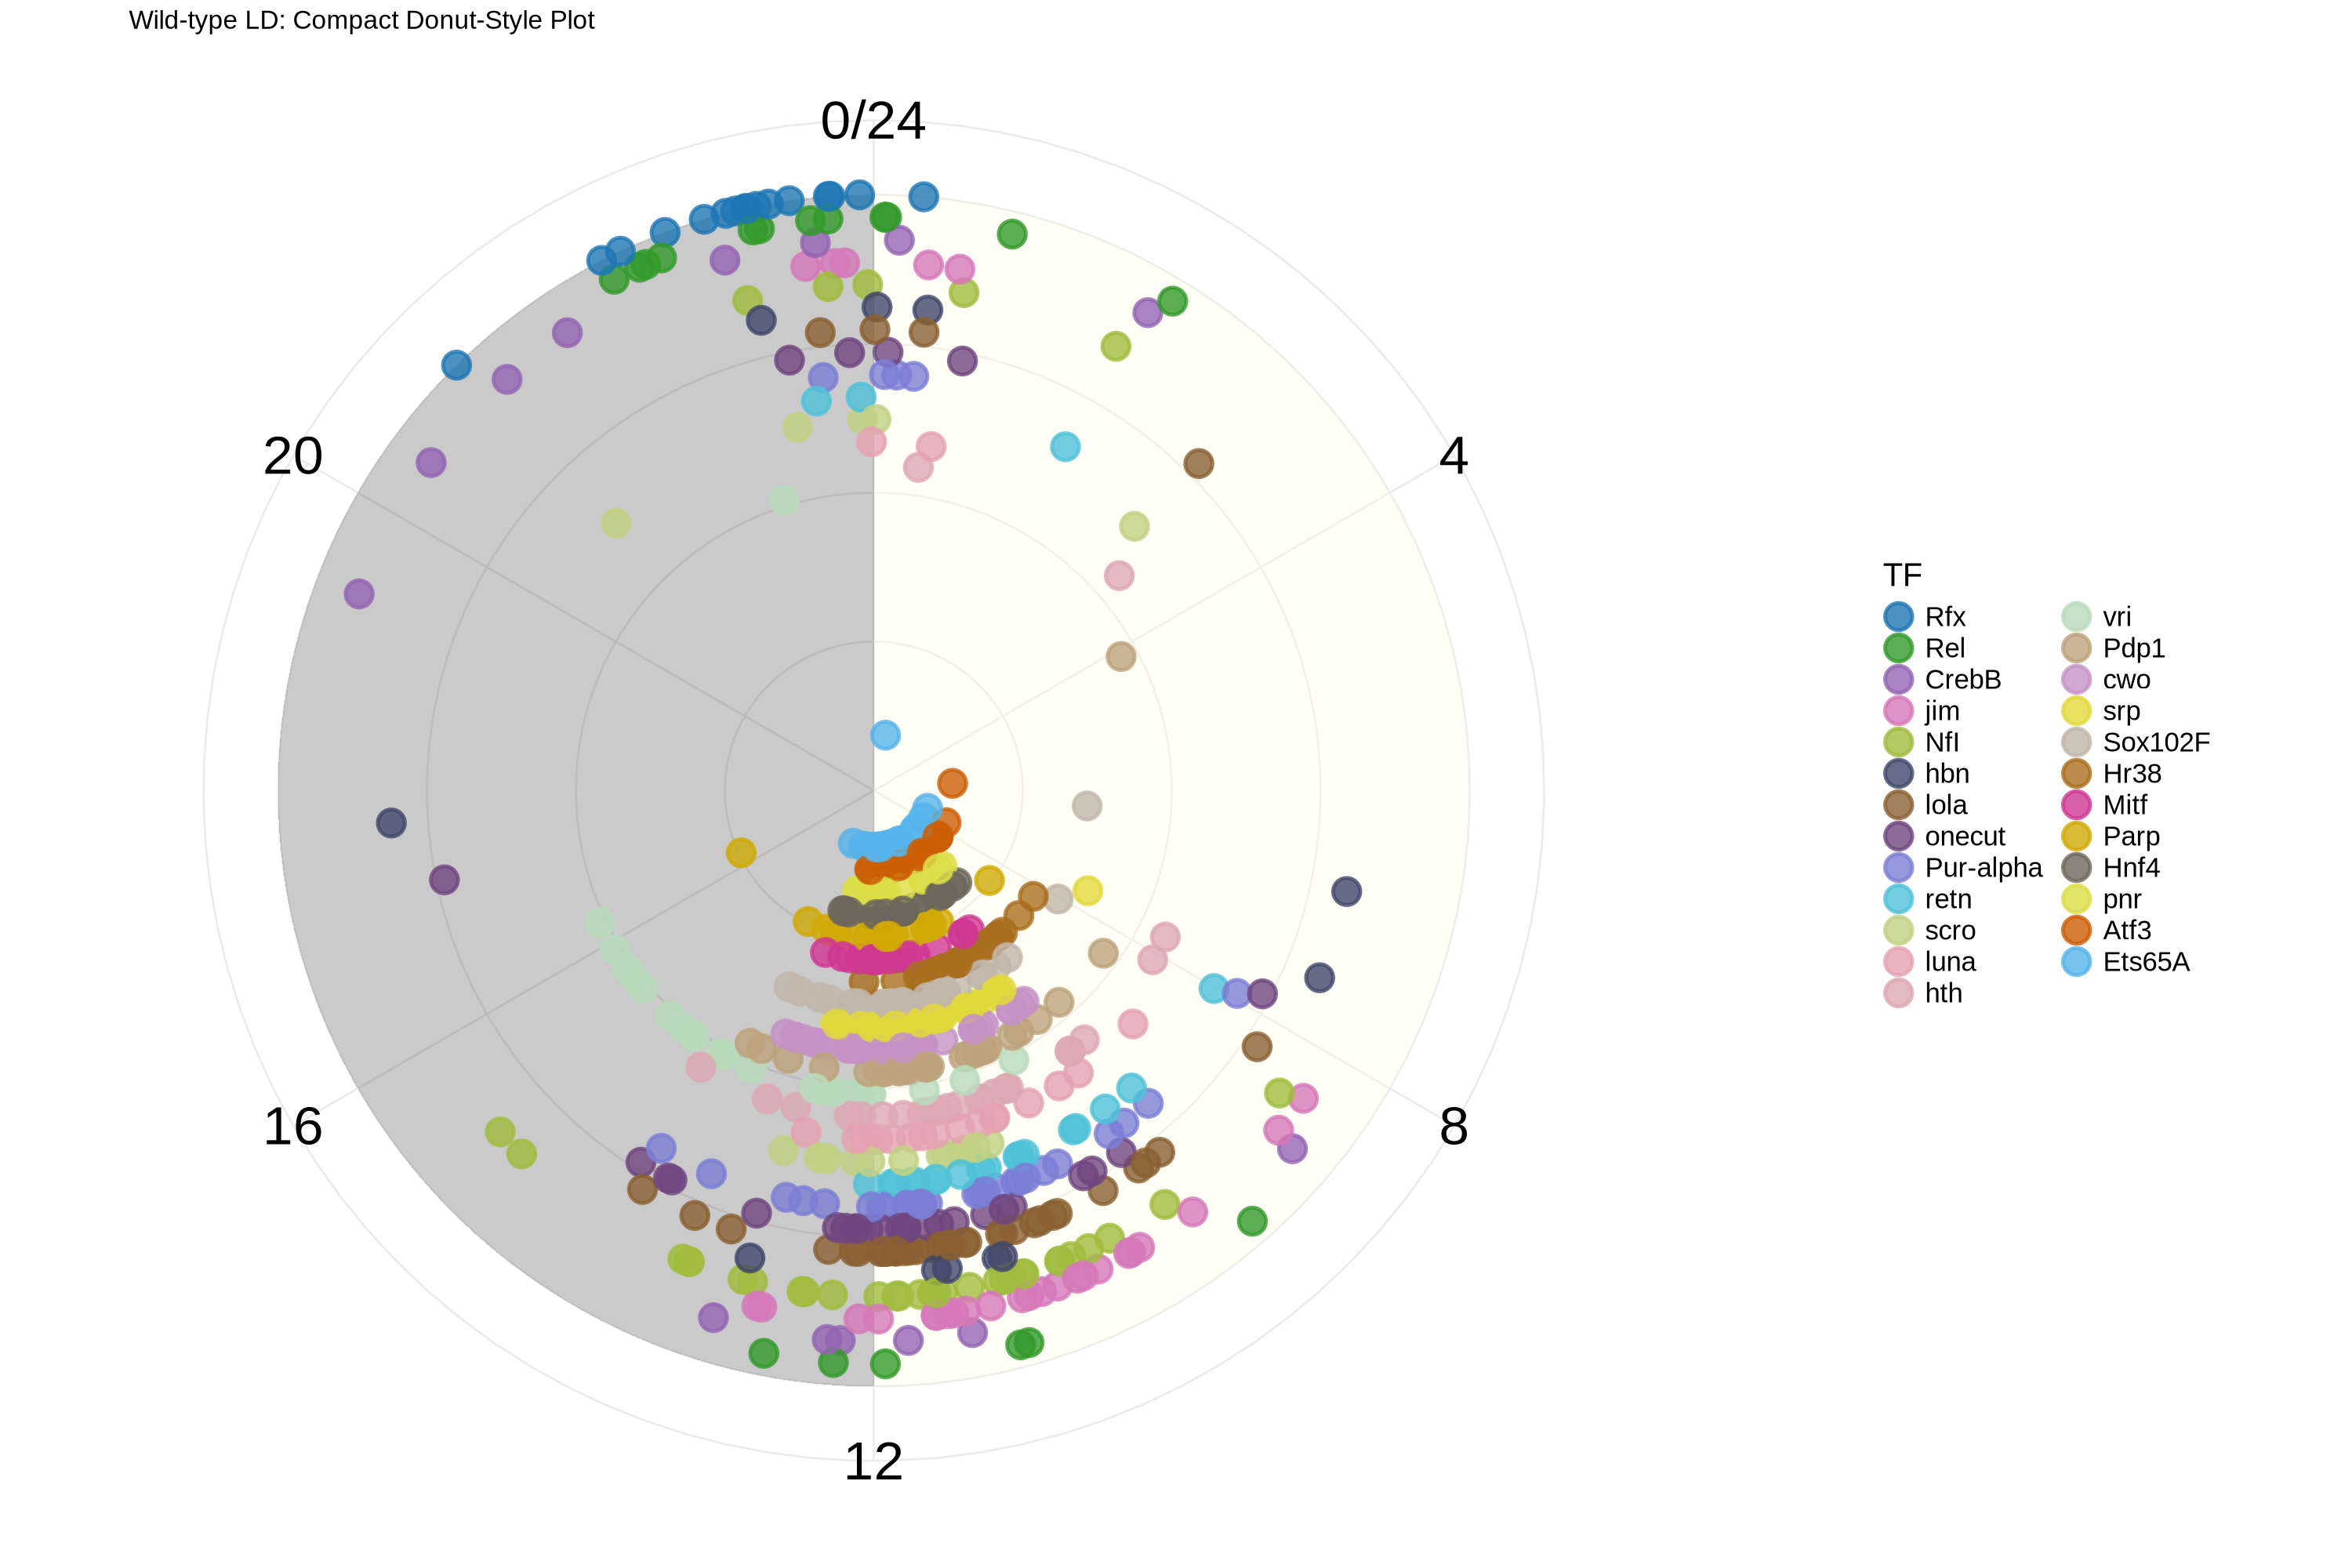

In [229]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c( "jumu"
             ,"Ets96B"
             ,"Fer1"
             ,"CG5641"
             ,"mid"
             ,"Hesr"
             ,"gce"
             ,"Rfx"
             ,"Hsf"
             ,"SoxN"
             ,"pho"
             ,"Rel"
             ,"TfAP.2"
             
             ,"B.H2"
             ,"Deaf1"
             ,"Met"
             ,"CrebB"
             ,"nej"
             
             ,"CG12605"
             ,"Sox14"
             ,"vri"
             ,"cwo"
             ,"Pdp1"
             ,"lola"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"Pur.alpha"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"luna"
             ,"svp"
             ,"Parp"
             ,"gl"
             ,"retn"
             ,"scro"
             ,"sage"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Dif"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")


raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=2, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


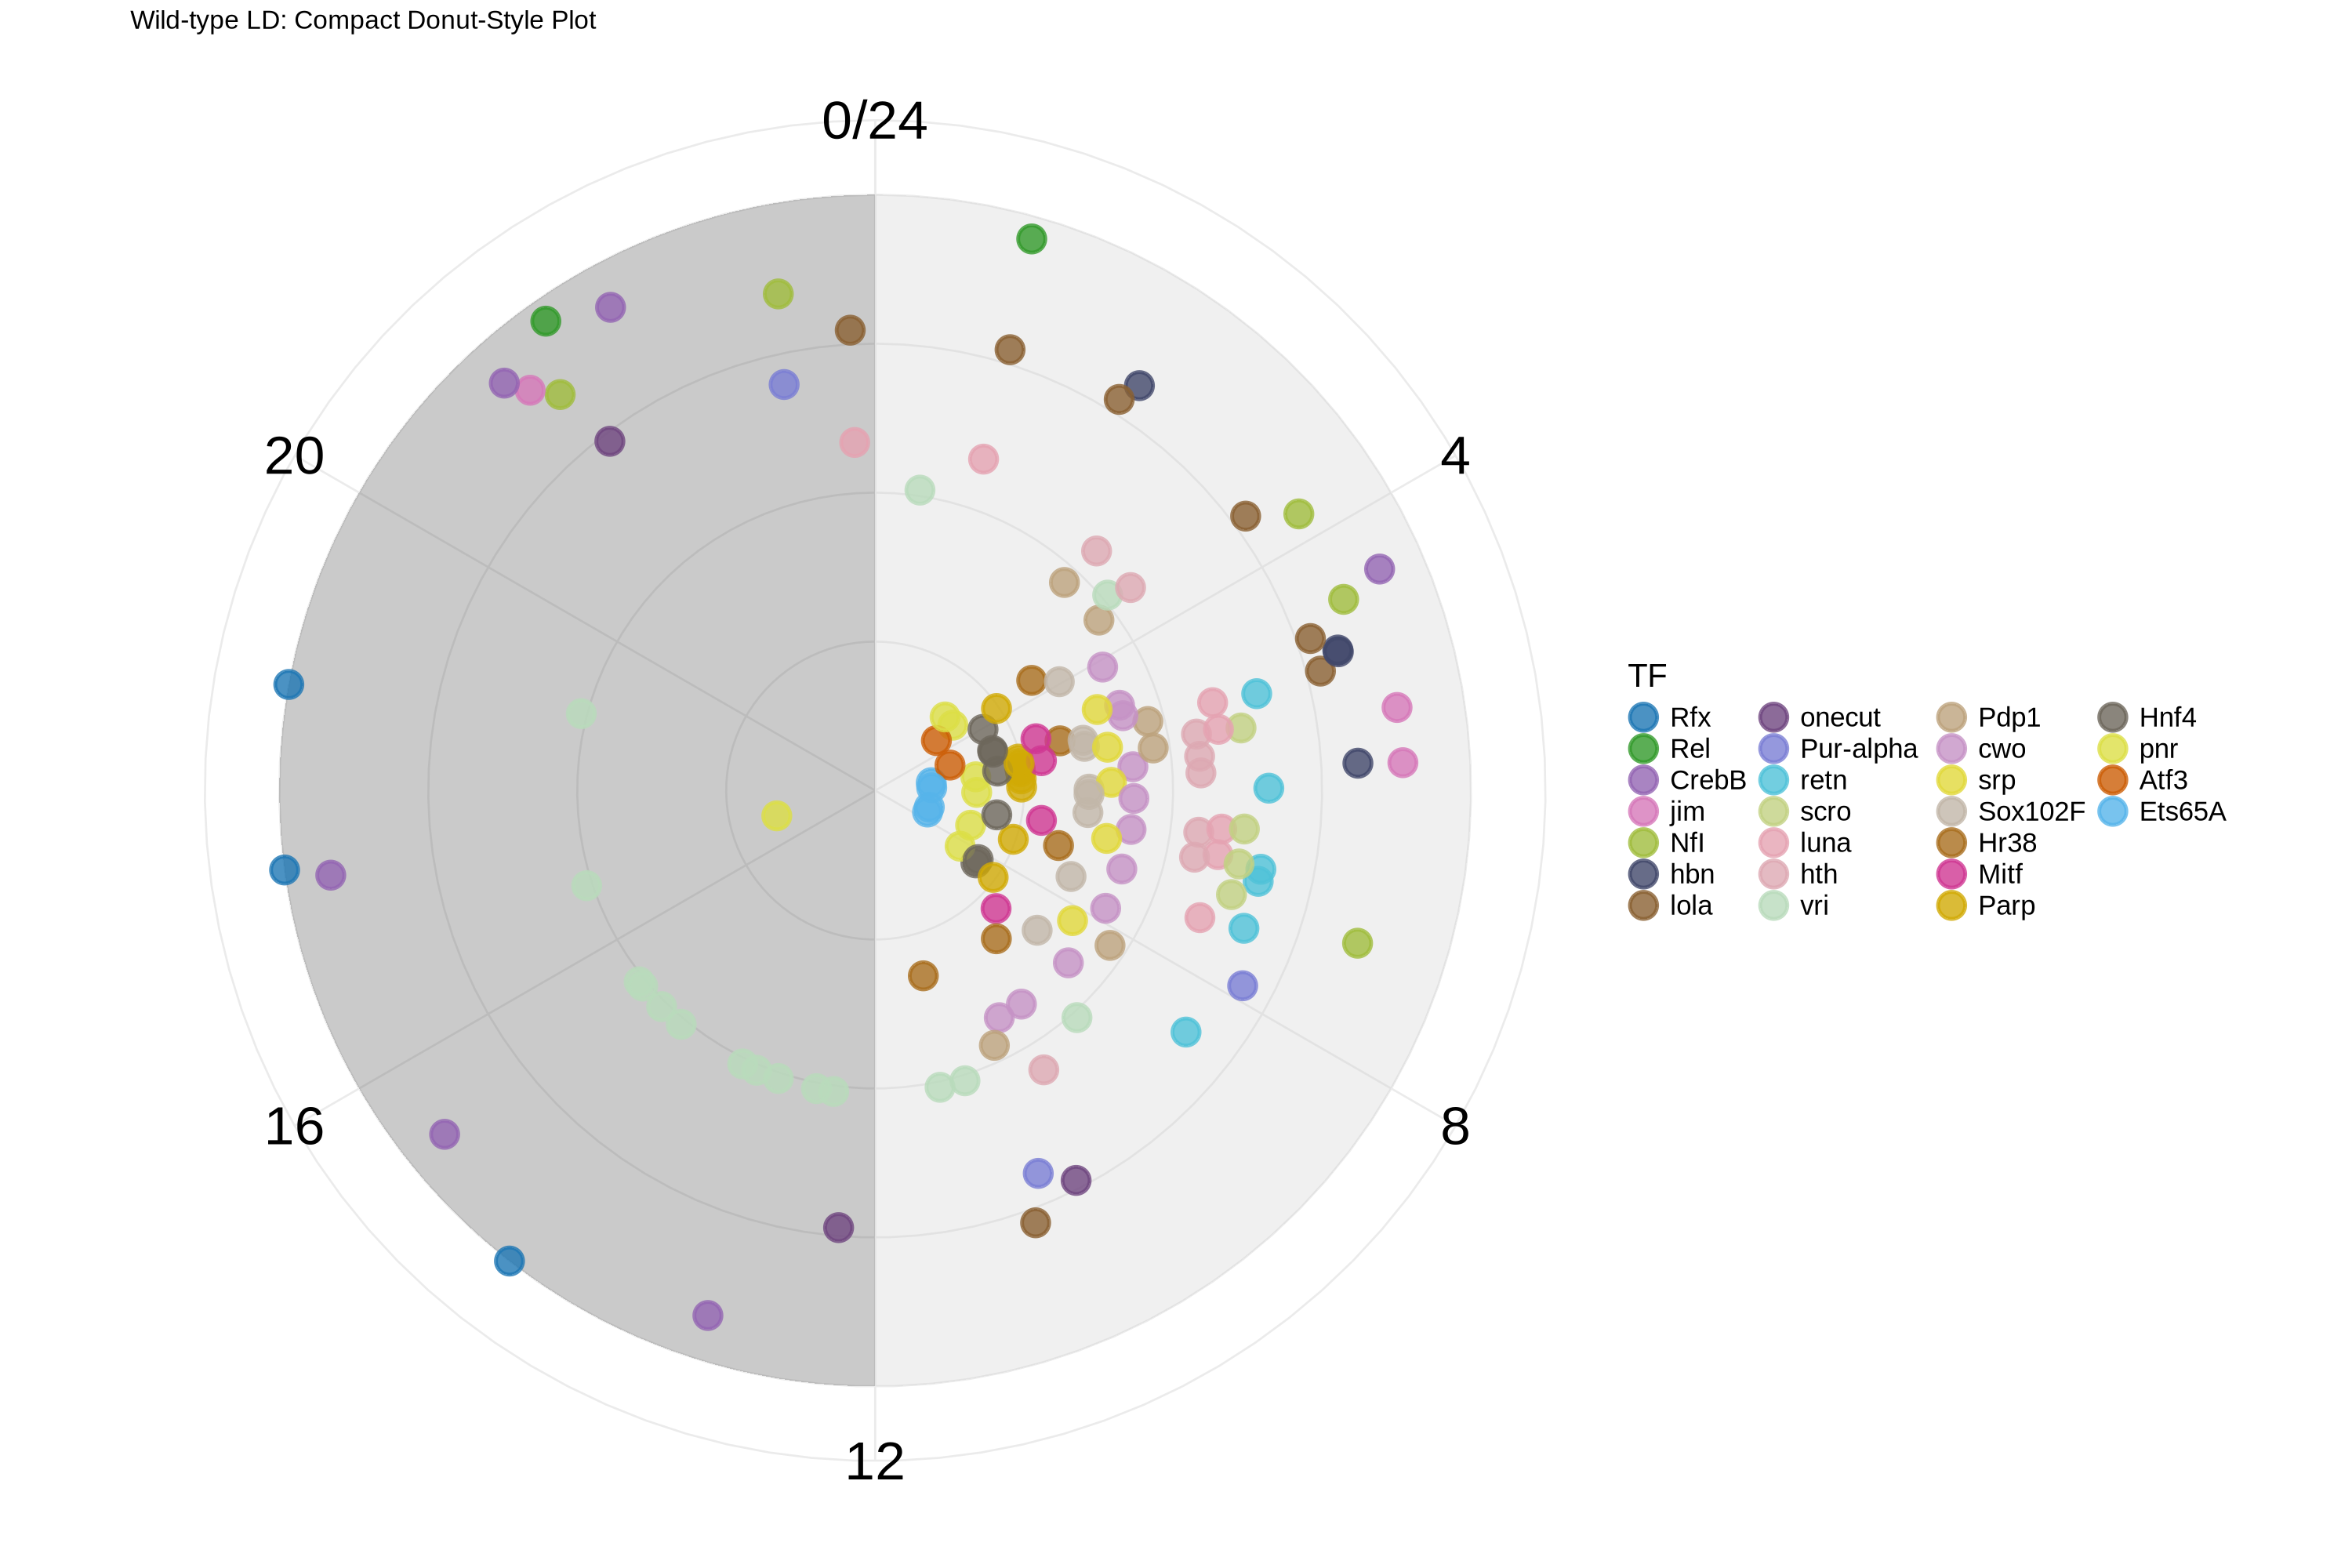

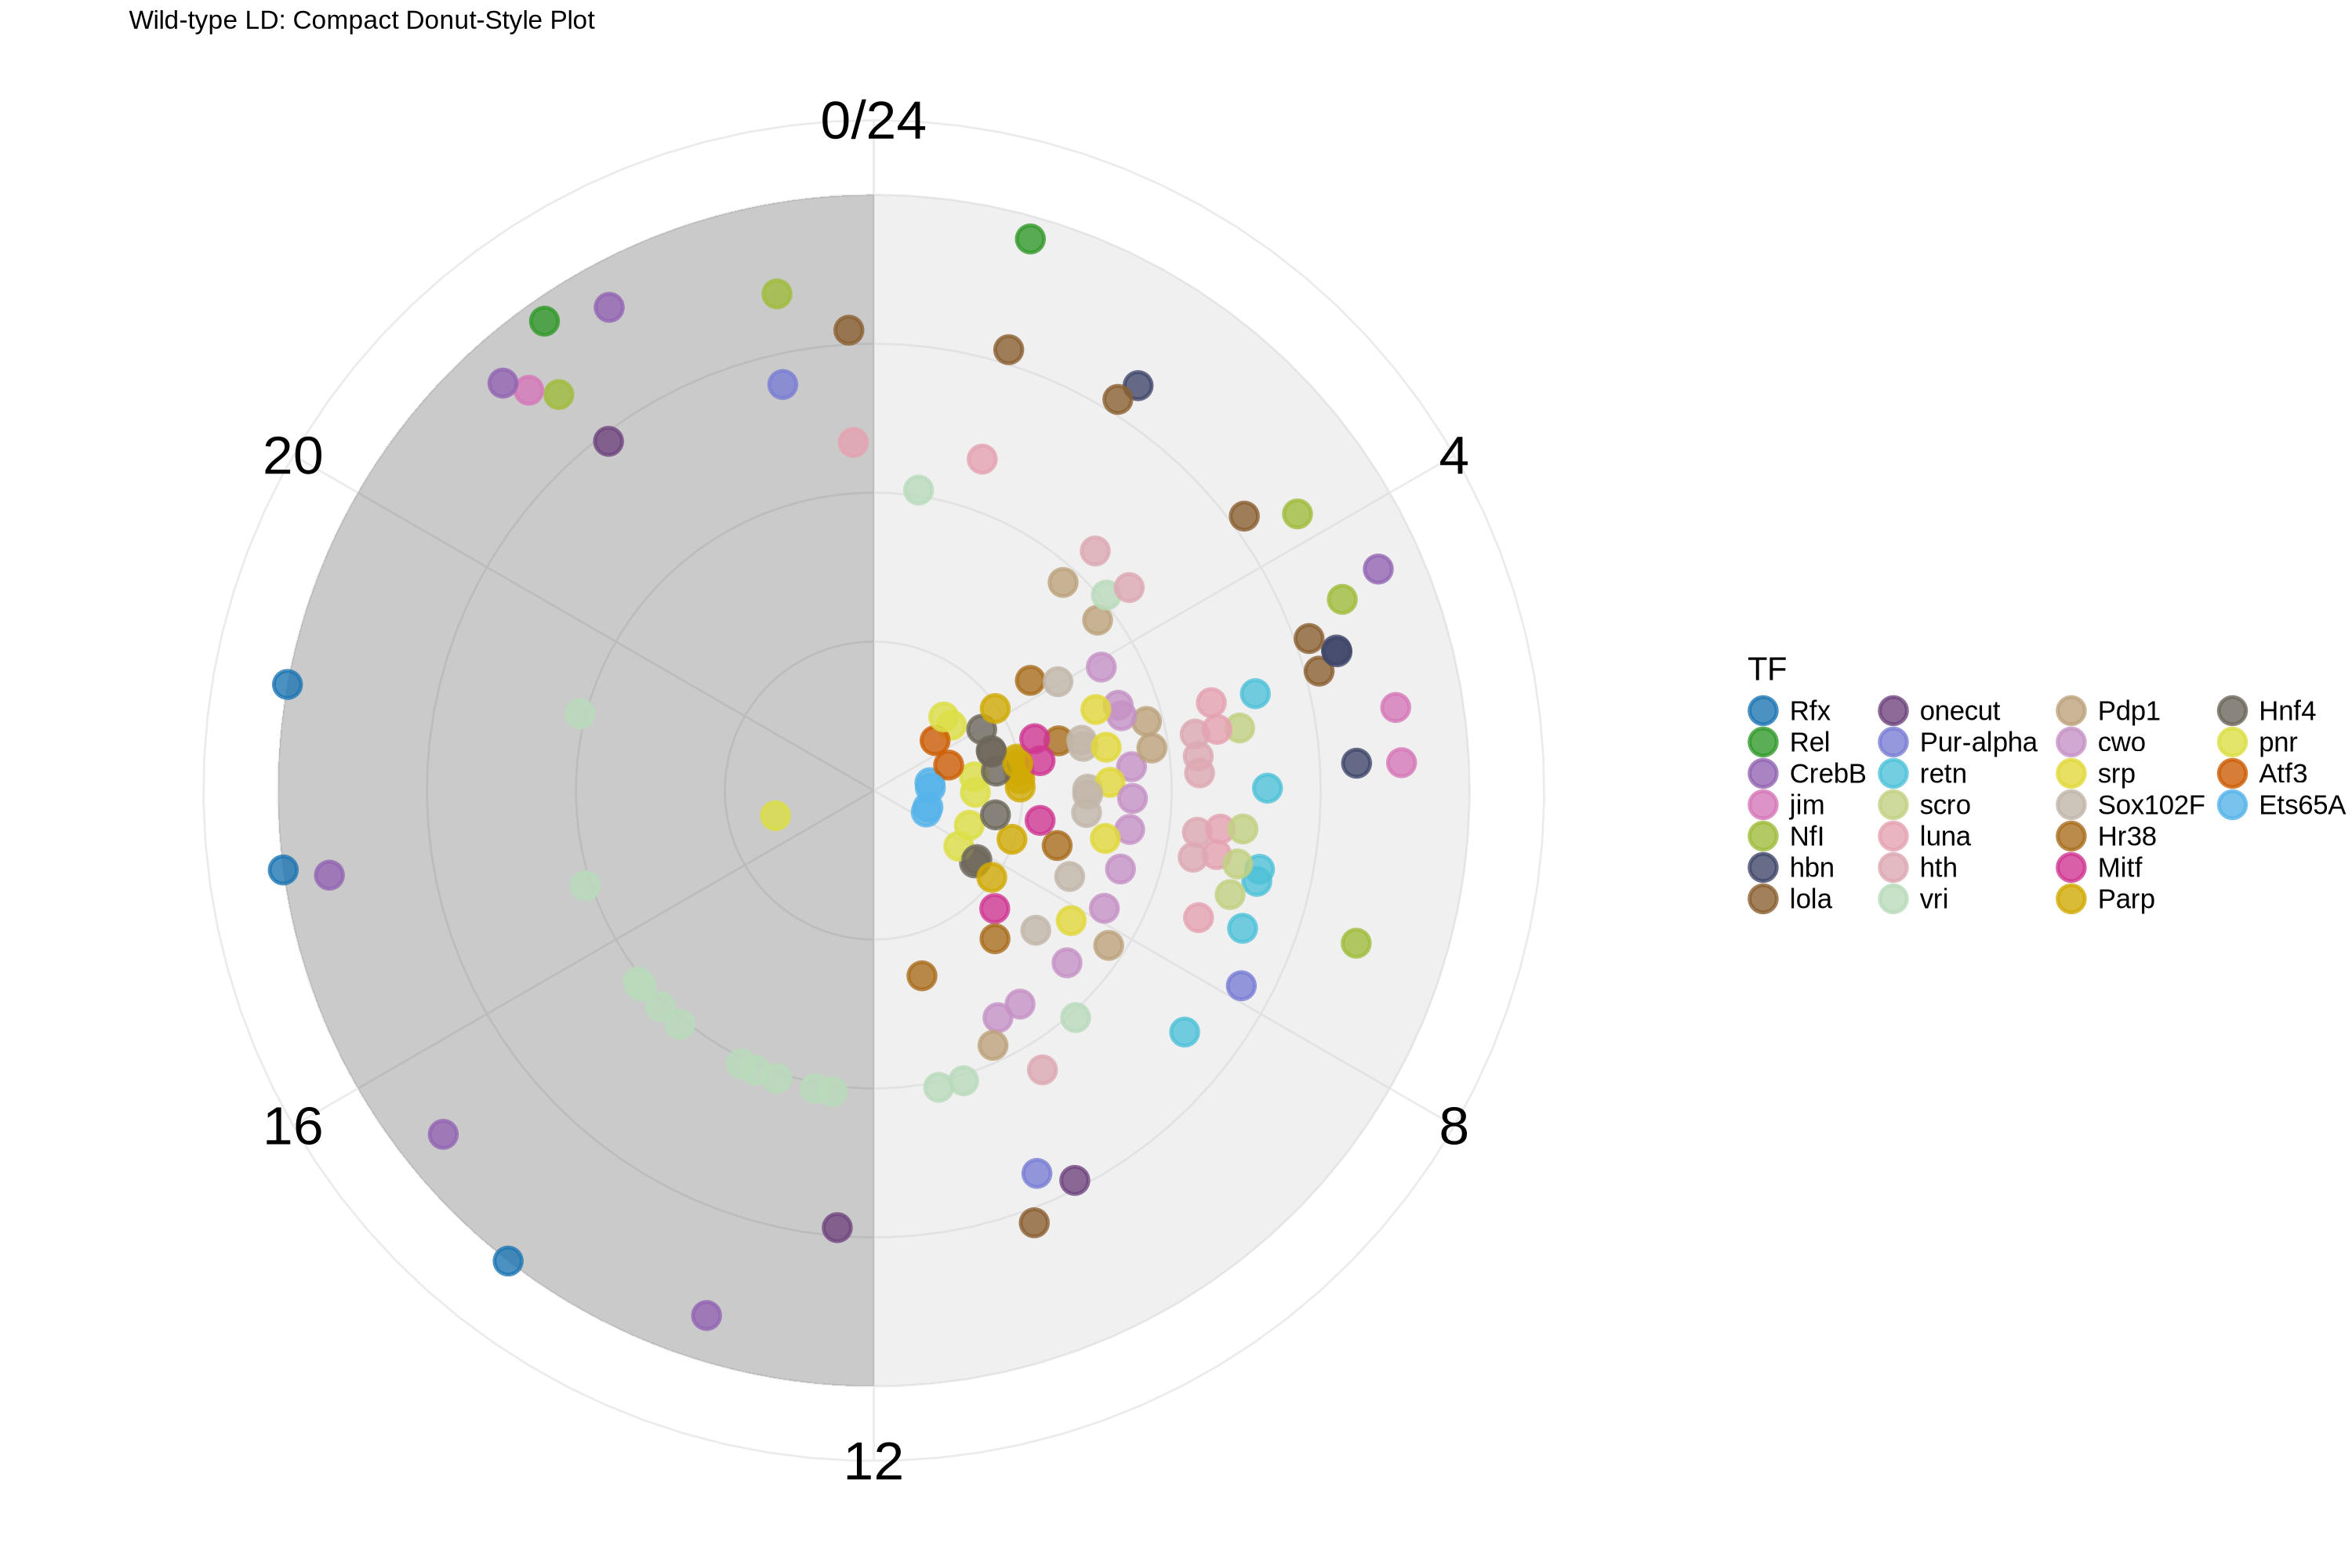

In [218]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c("lola"
             ,"jumu"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"CG5641"
             ,"cwo"
             ,"Pdp1"
             ,"Pur.alpha"
             ,"gce"
             ,"mid"
             ,"Hesr"
             ,"nej"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"Sox14"
             ,"luna"
             ,"svp"
             ,"Deaf1"
             ,"Met"
             ,"Parp"
             ,"gl"
             ,"Hsf"
             ,"SoxN"
             ,"retn"
             ,"scro"
             ,"vri"
             ,"pho"
             ,"sage"
             ,"Rel"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Ets96B"
             ,"Fer1"
             ,"CG12605"
             ,"Dif"
             ,"Rfx"
             ,"TfAP.2"
             ,"B.H2"
             ,"CrebB"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")


raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "E.spl.m3.HLH" = "E(spl)m3-HLH",
    "Blimp.1" = "Blimp-1",
    "Nf.YA"     = "Nf-YA",
    "Pur.alpha" = "Pur-alpha",
    "REPTOR.BP" = "REPTOR-BP",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


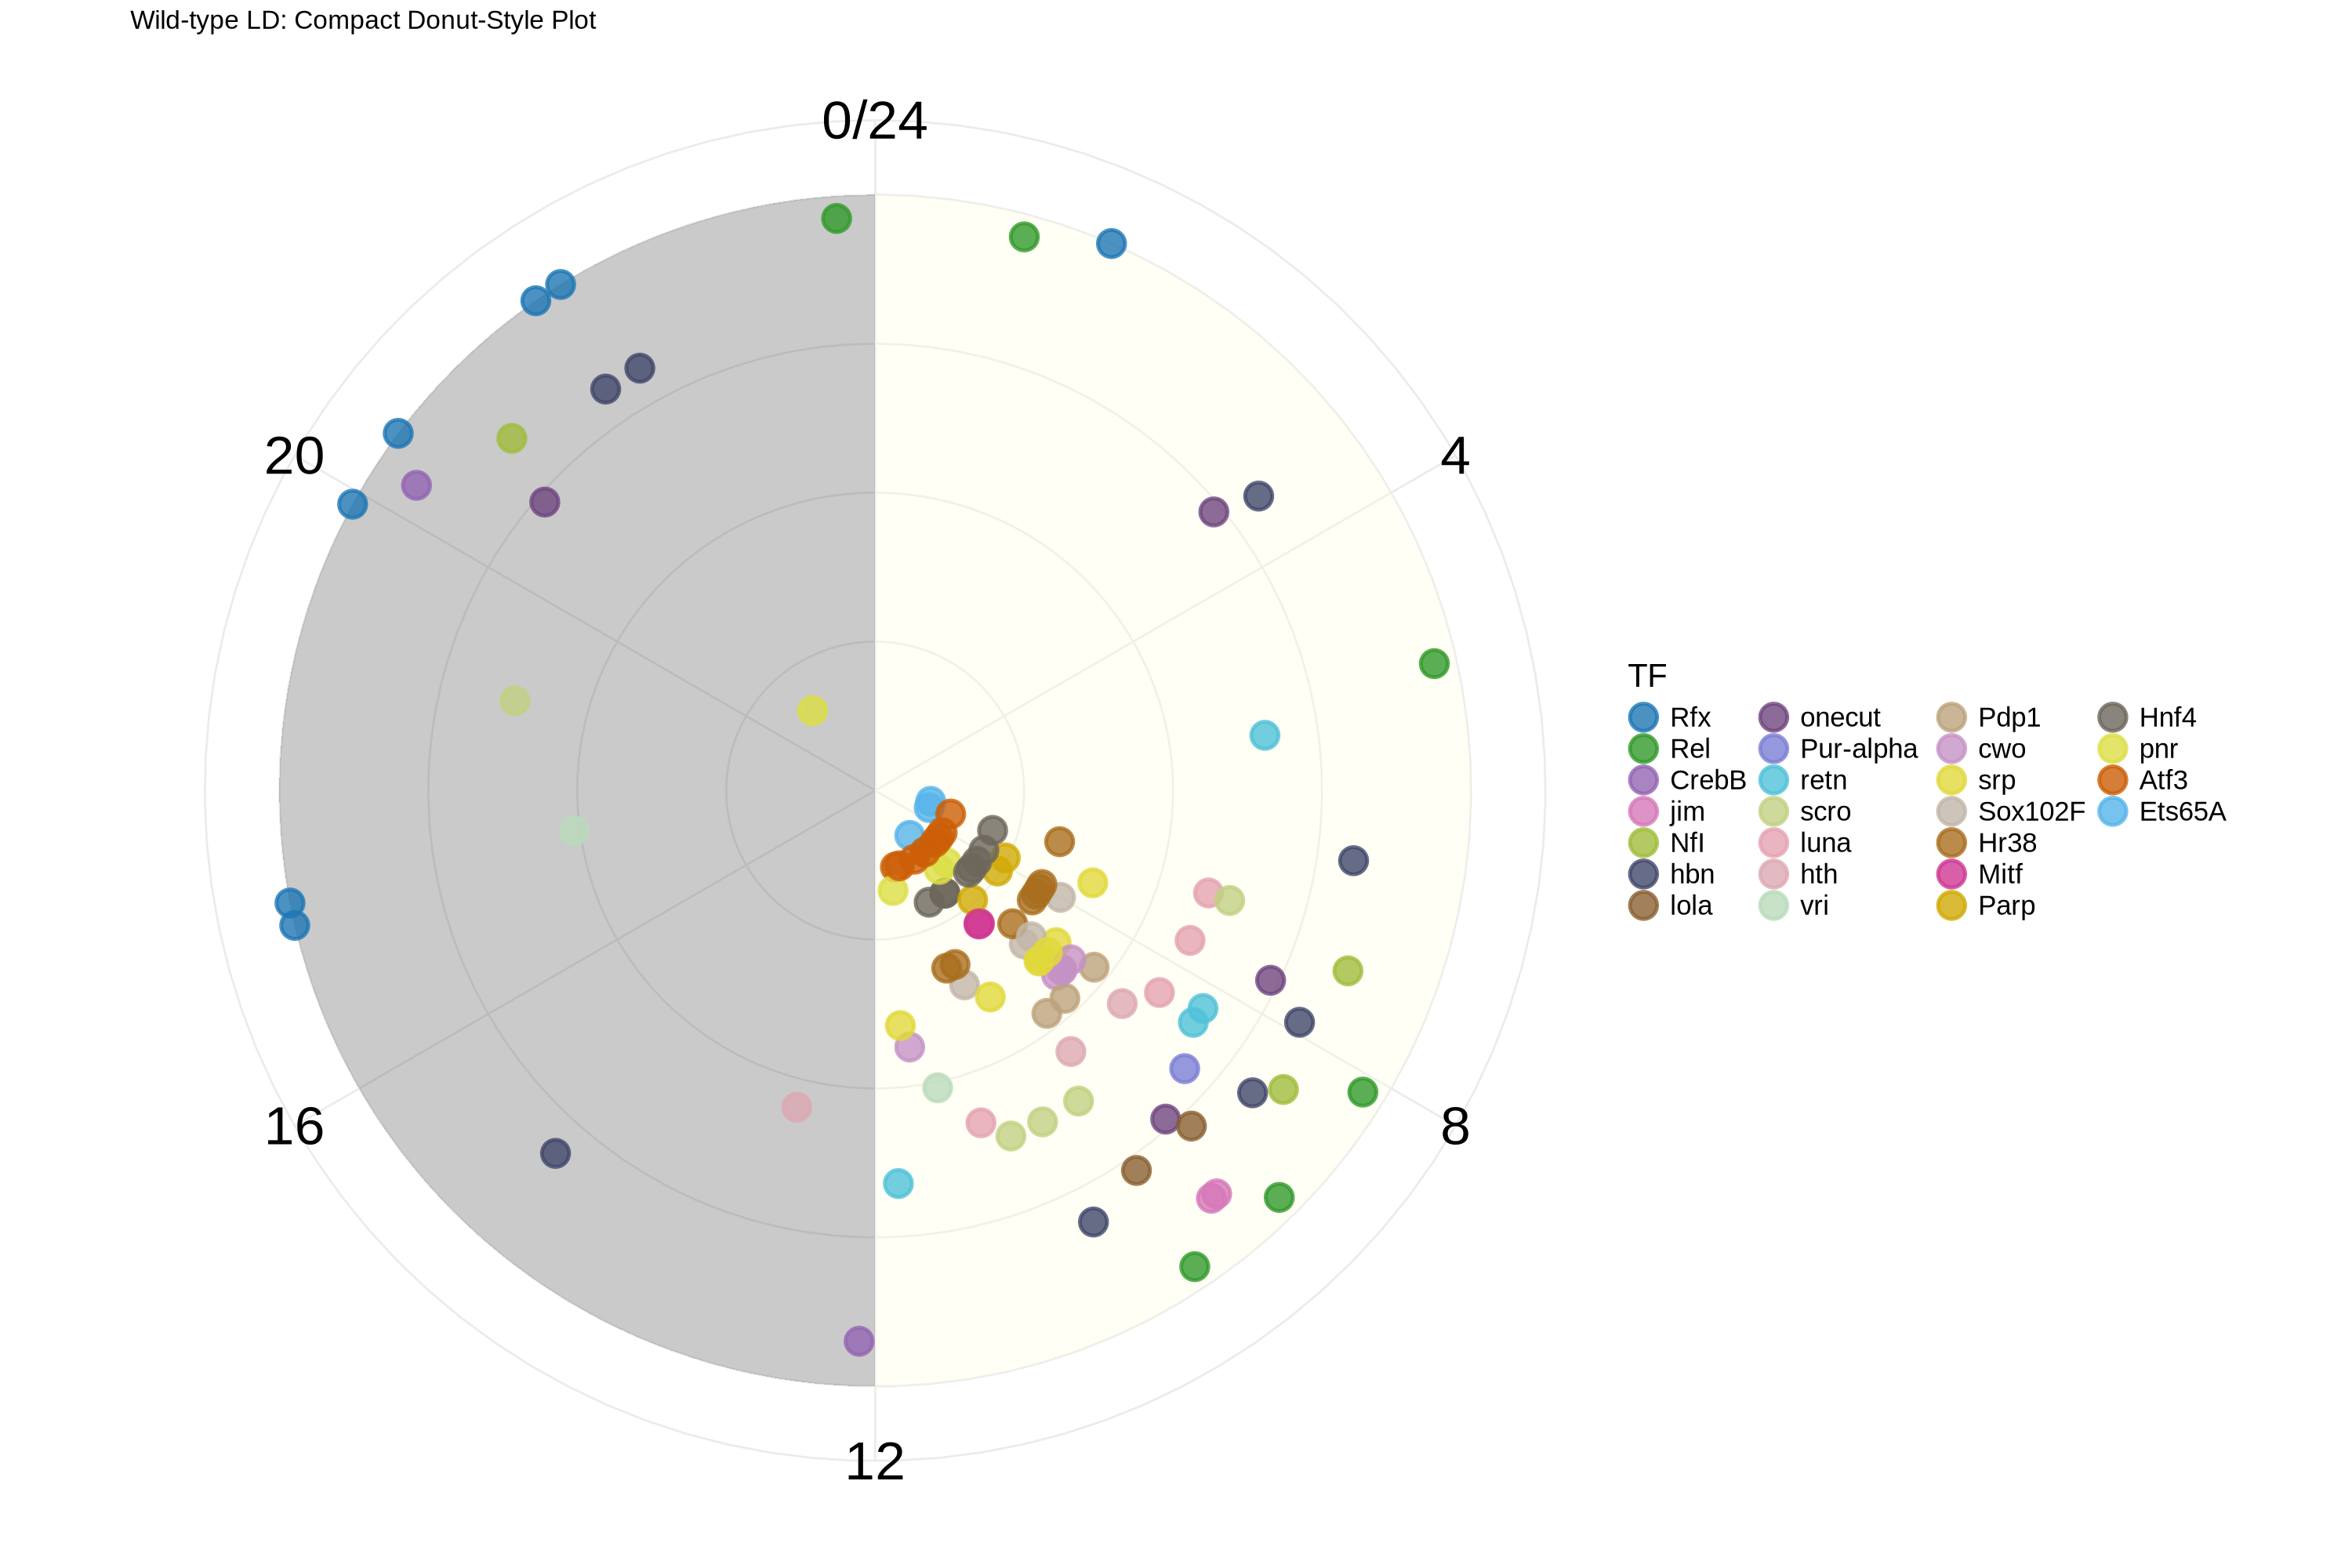

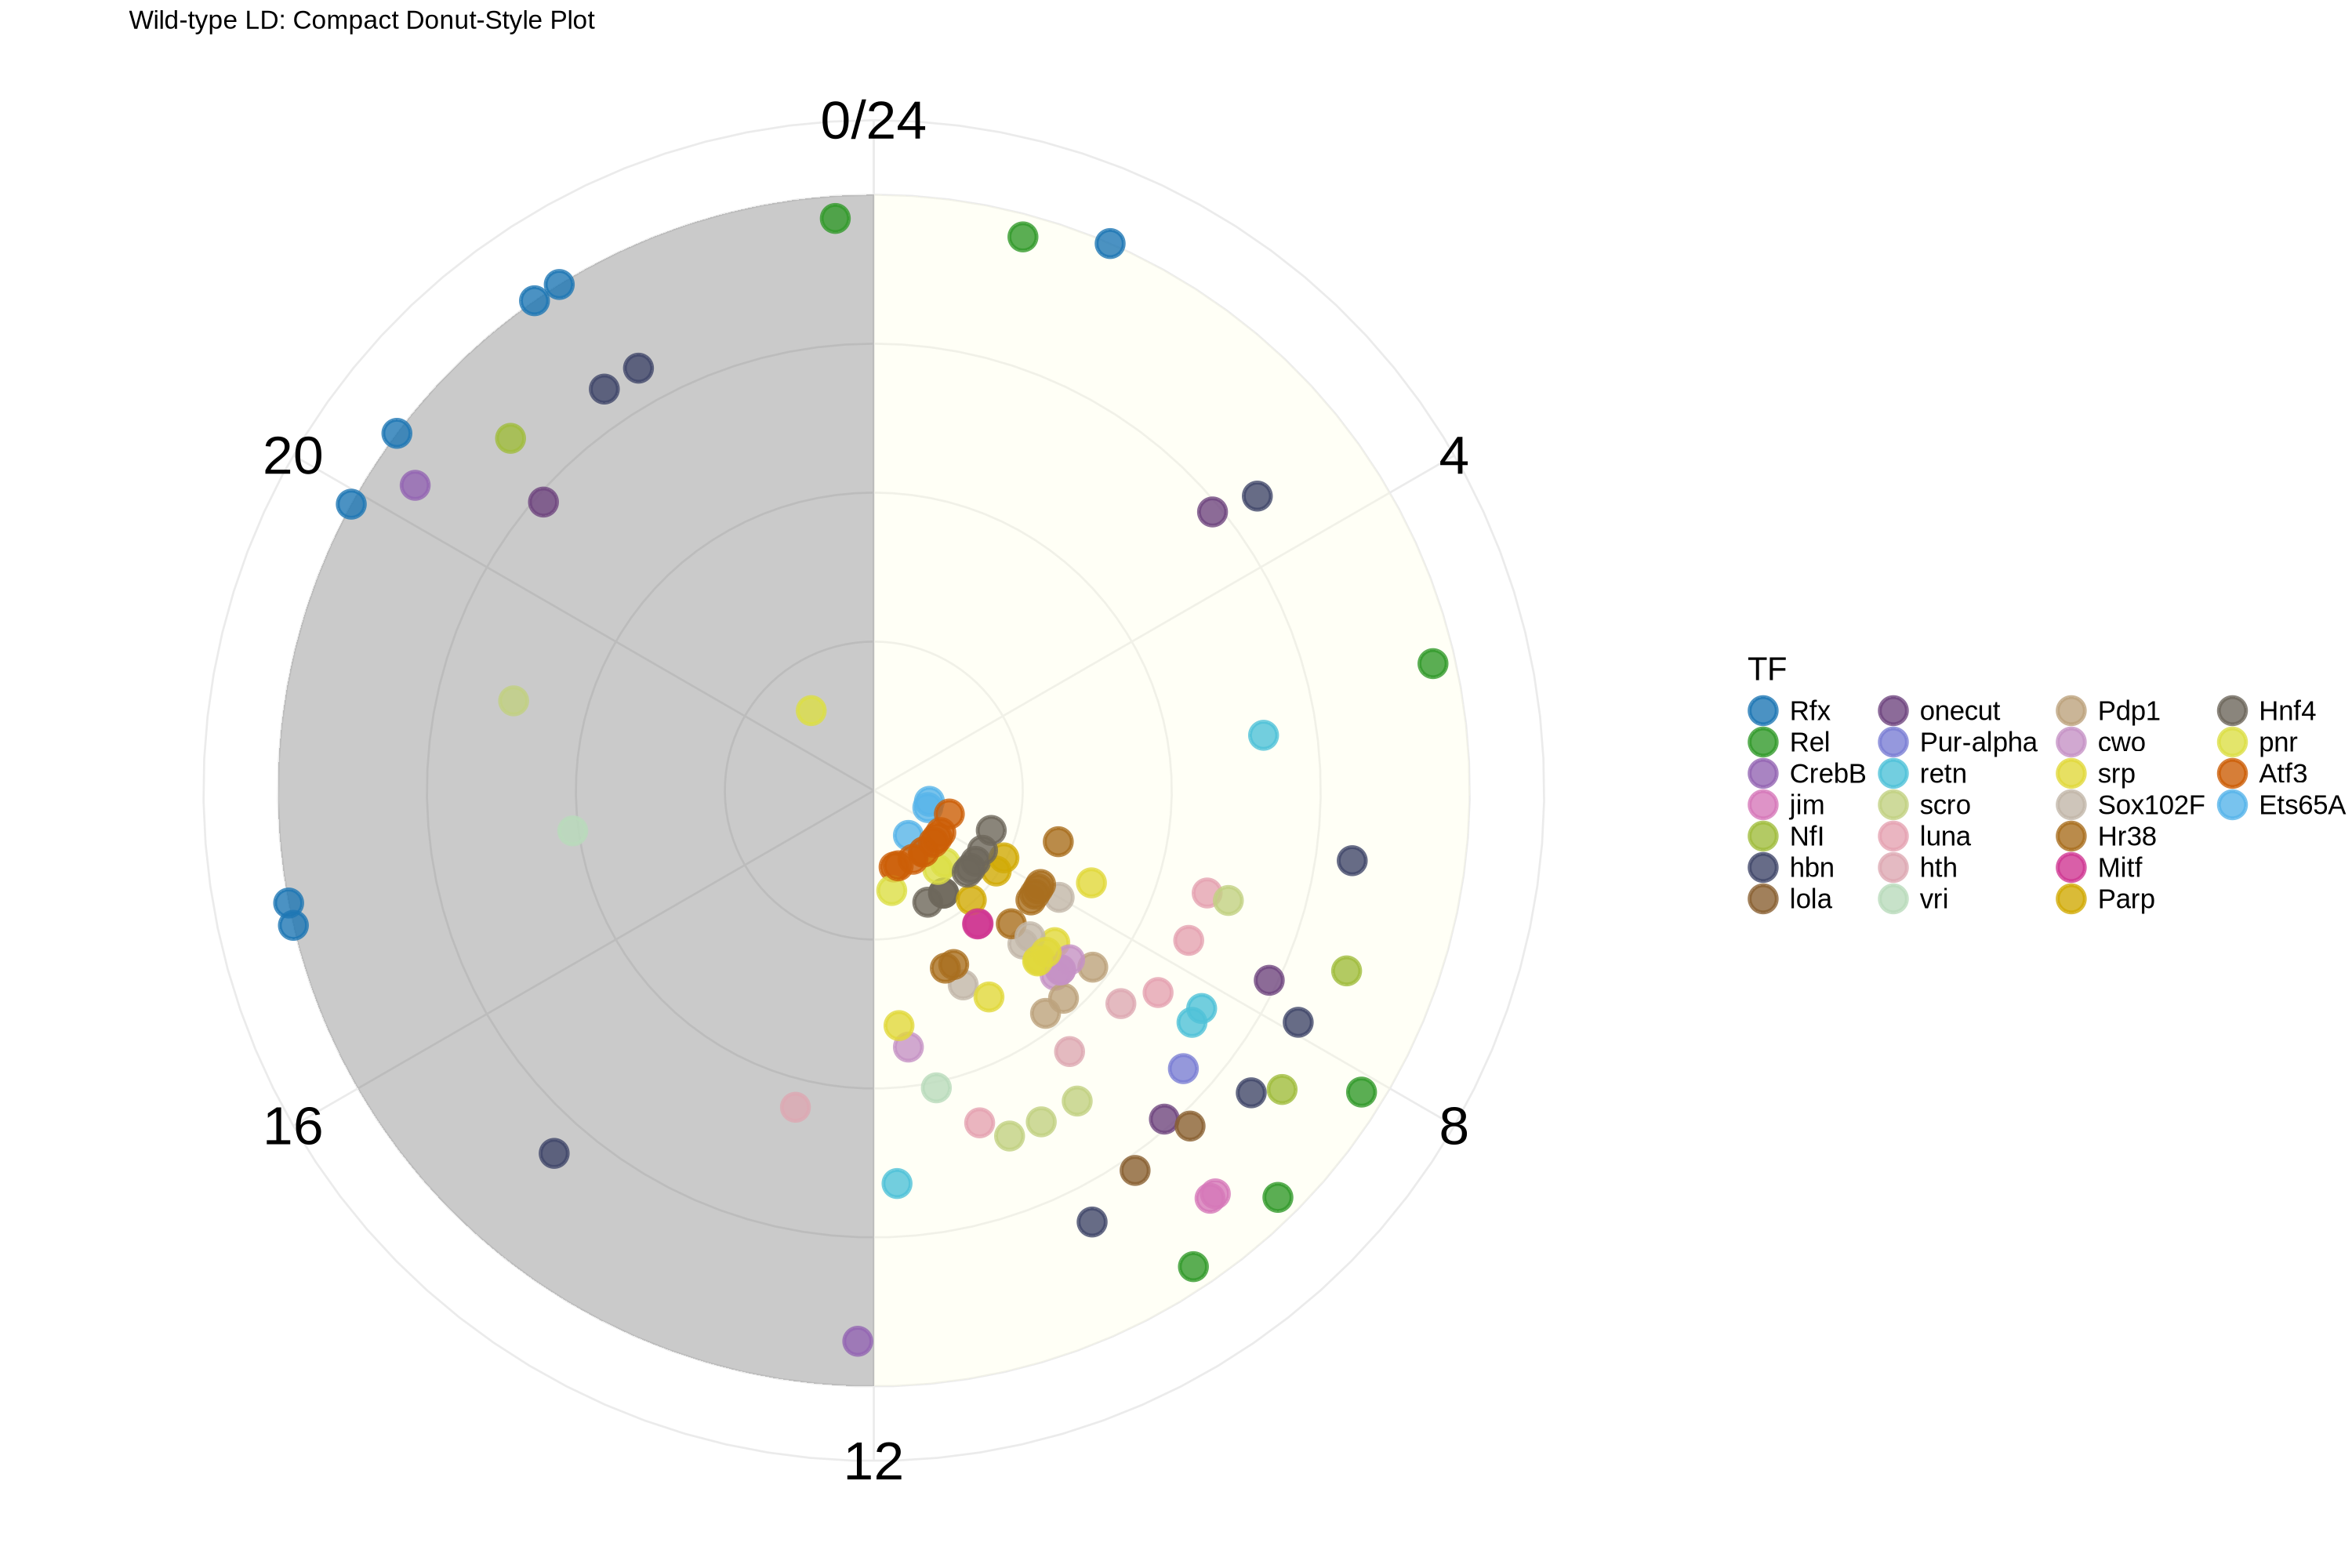

In [219]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c("lola"
             ,"jumu"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"CG5641"
             ,"cwo"
             ,"Pdp1"
             ,"Pur.alpha"
             ,"gce"
             ,"mid"
             ,"Hesr"
             ,"nej"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"Sox14"
             ,"luna"
             ,"svp"
             ,"Deaf1"
             ,"Met"
             ,"Parp"
             ,"gl"
             ,"Hsf"
             ,"SoxN"
             ,"retn"
             ,"scro"
             ,"vri"
             ,"pho"
             ,"sage"
             ,"Rel"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Ets96B"
             ,"Fer1"
             ,"CG12605"
             ,"Dif"
             ,"Rfx"
             ,"TfAP.2"
             ,"B.H2"
             ,"CrebB"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")


raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "E.spl.m3.HLH" = "E(spl)m3-HLH",
    "Blimp.1" = "Blimp-1",
    "Nf.YA"     = "Nf-YA",
    "Pur.alpha" = "Pur-alpha",
    "REPTOR.BP" = "REPTOR-BP",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


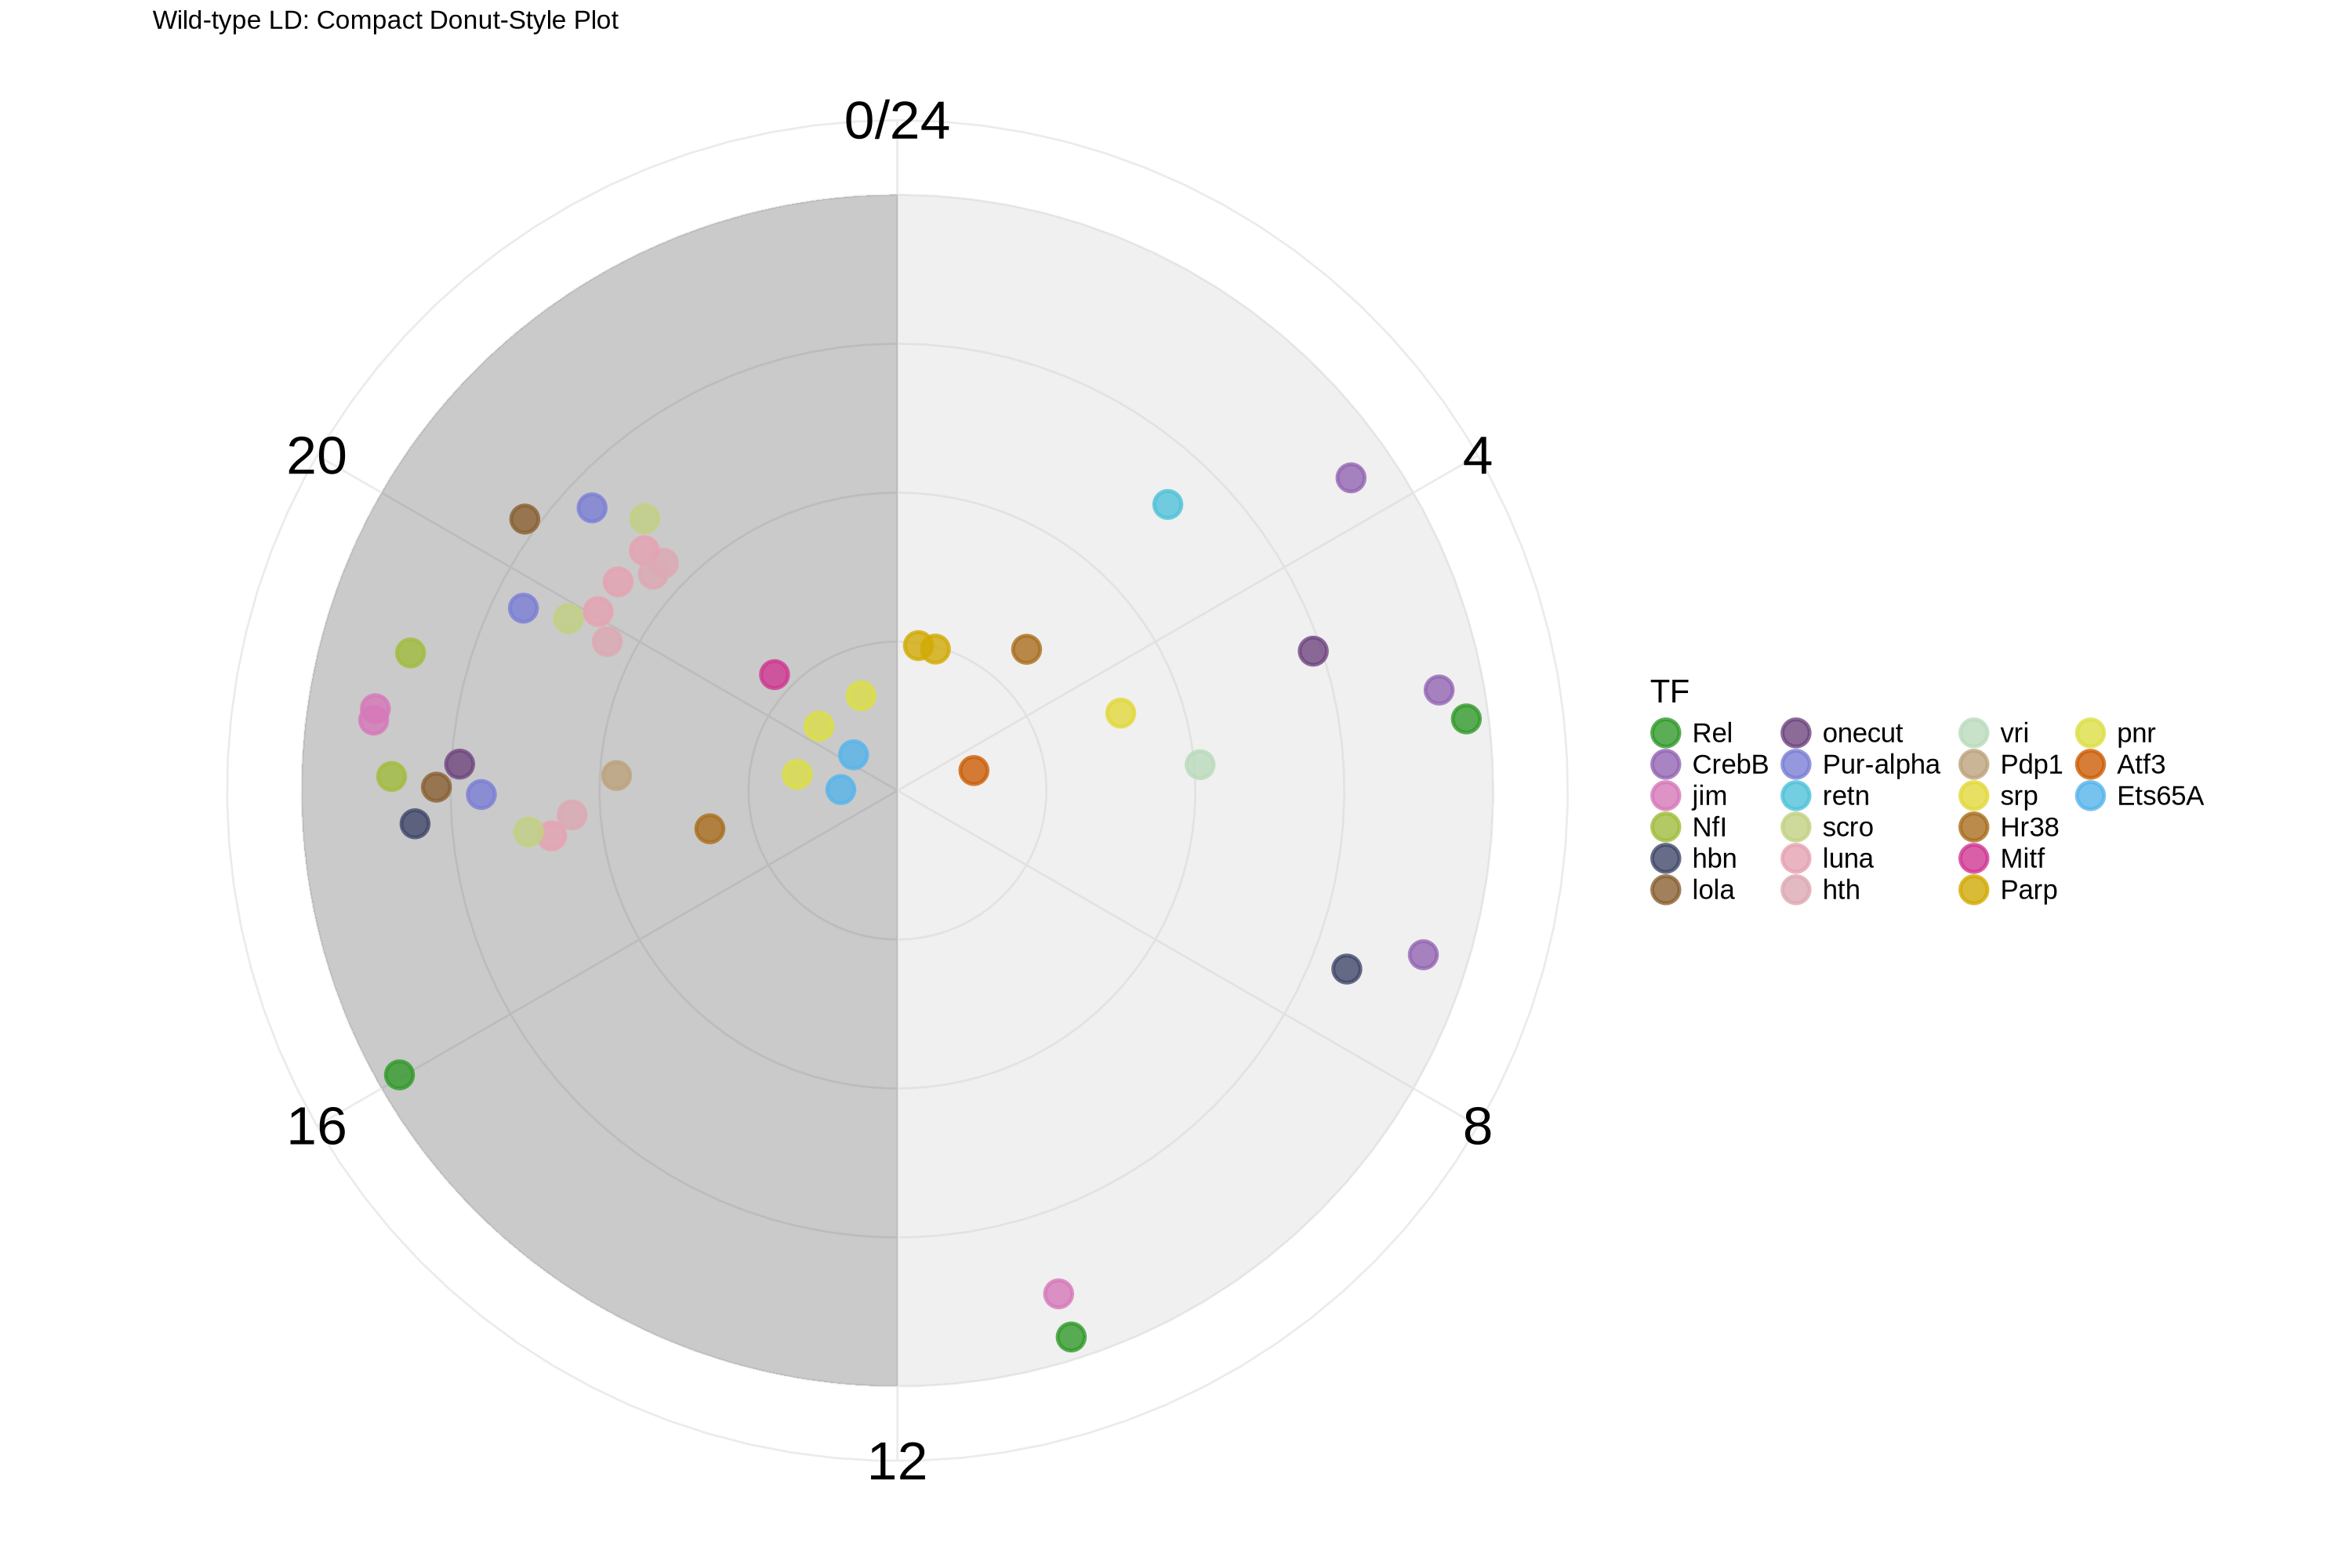

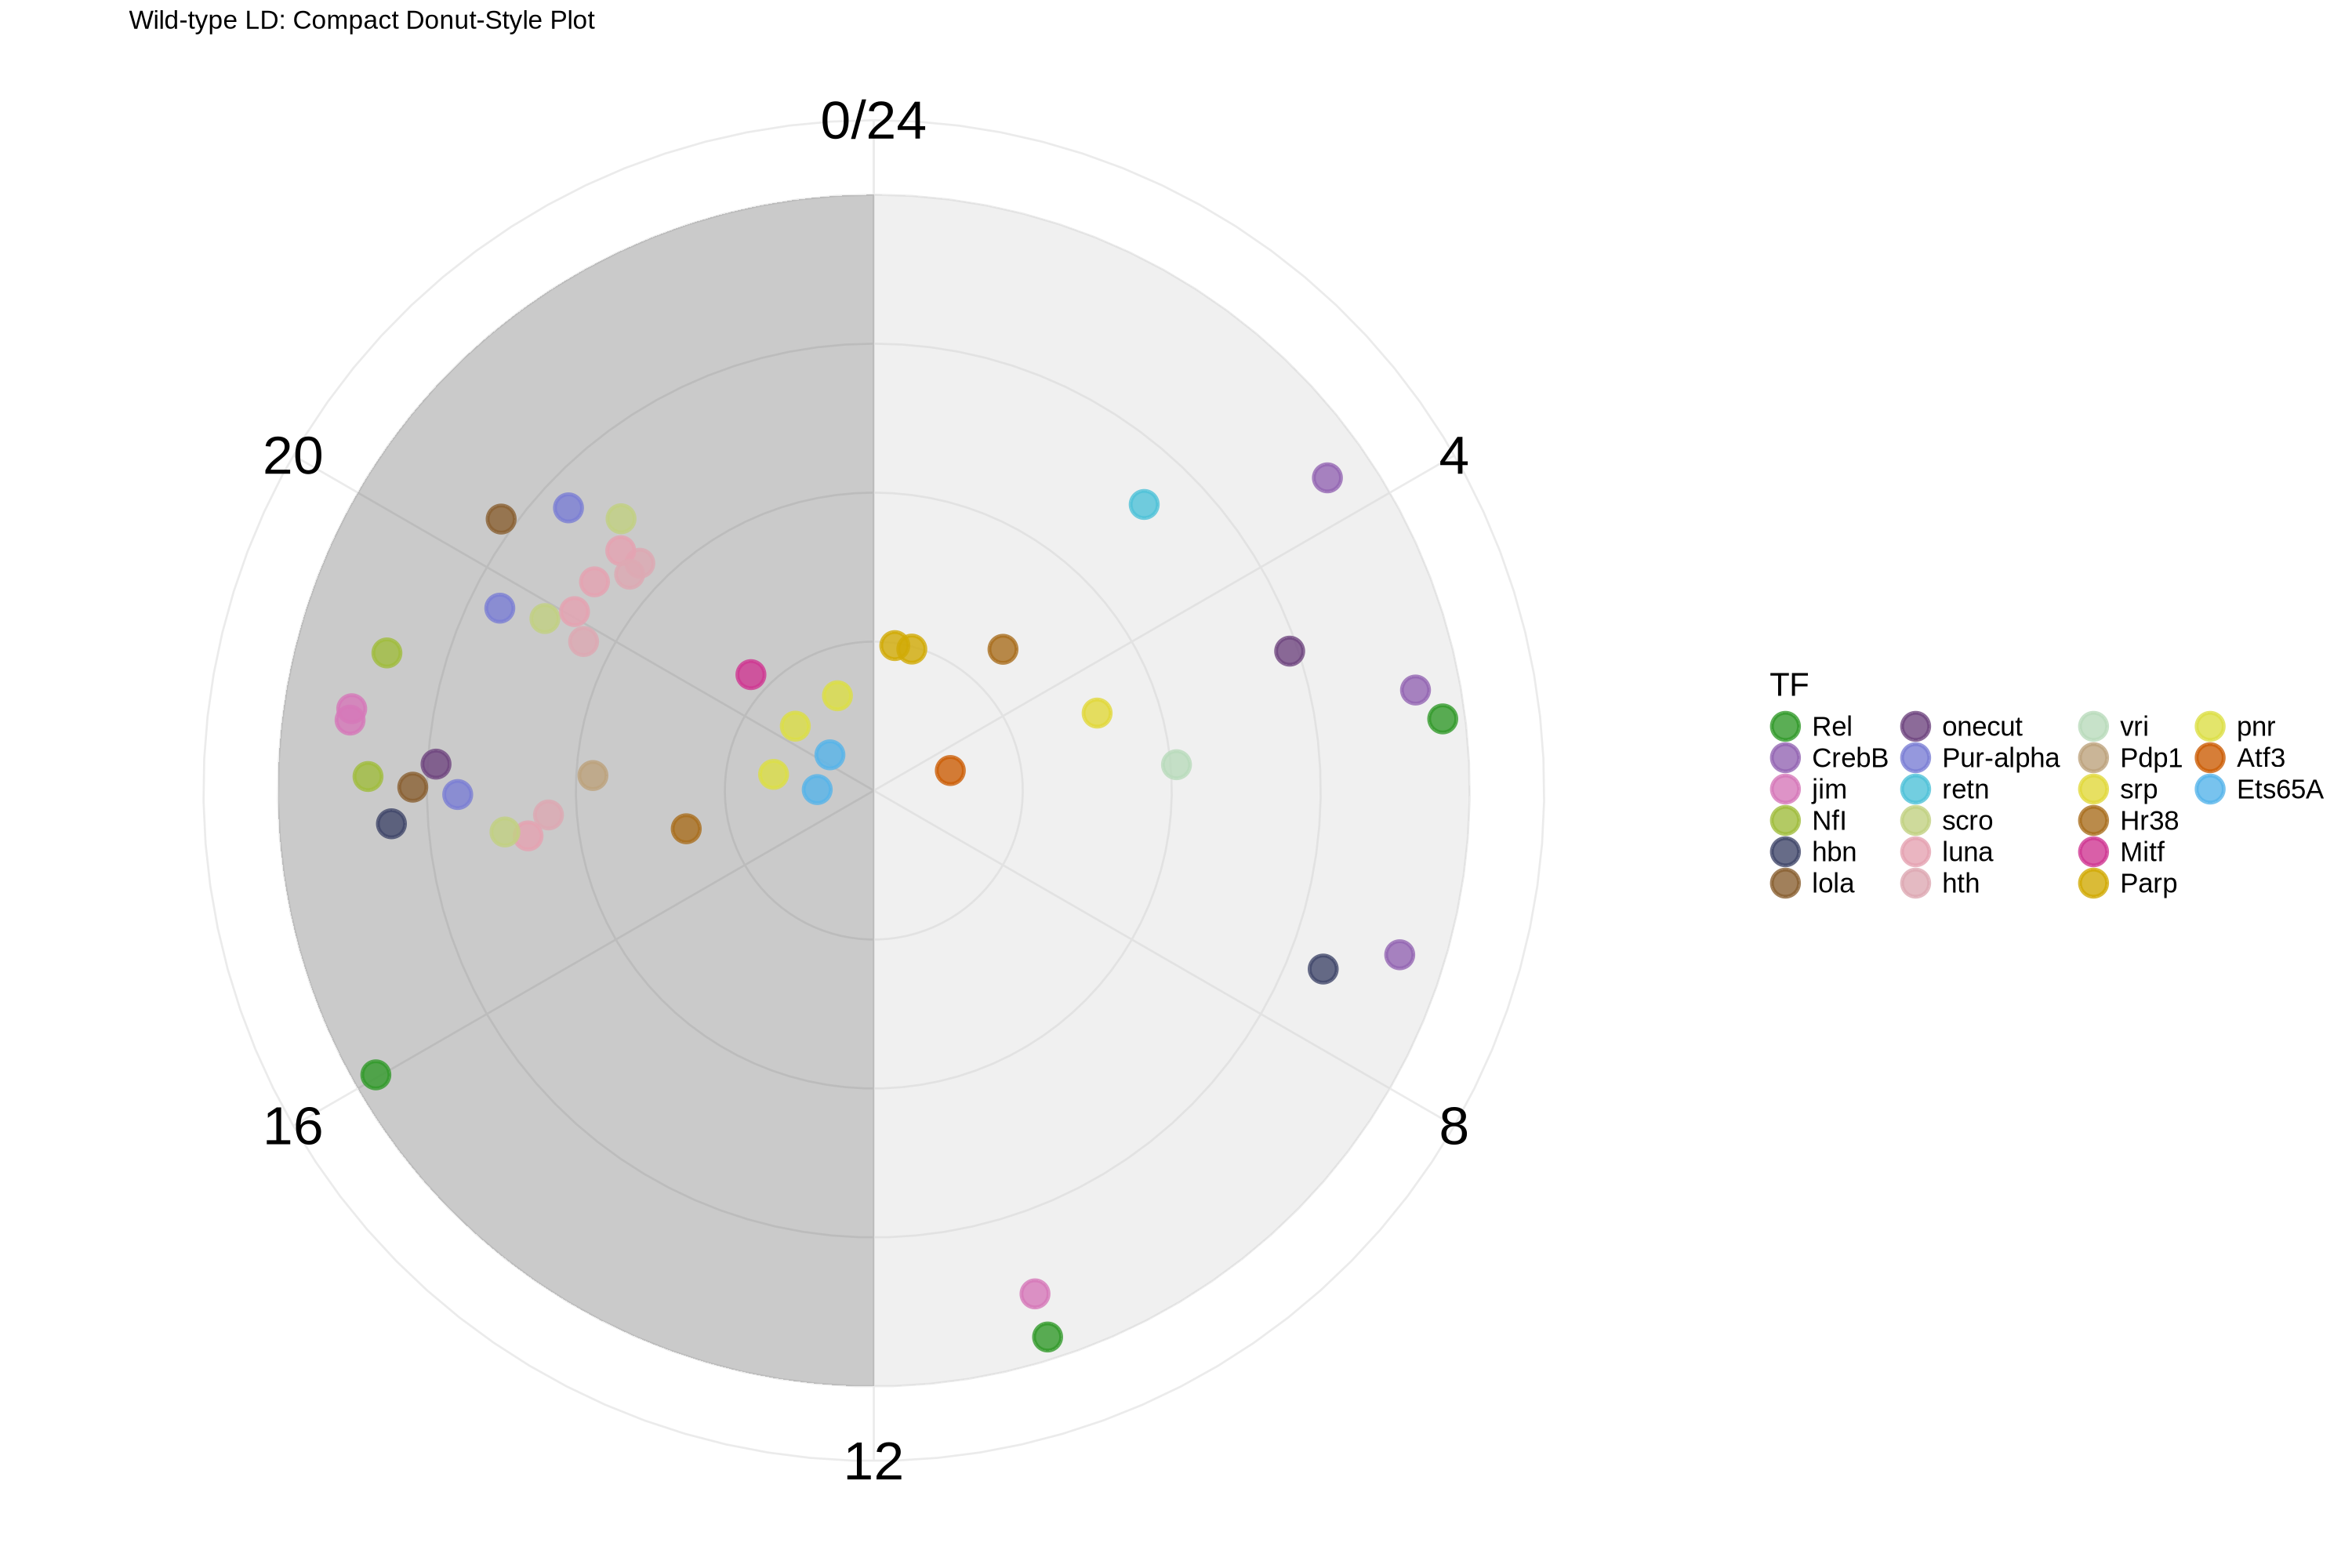

In [220]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c("lola"
             ,"jumu"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"CG5641"
             ,"cwo"
             ,"Pdp1"
             ,"Pur.alpha"
             ,"gce"
             ,"mid"
             ,"Hesr"
             ,"nej"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"Sox14"
             ,"luna"
             ,"svp"
             ,"Deaf1"
             ,"Met"
             ,"Parp"
             ,"gl"
             ,"Hsf"
             ,"SoxN"
             ,"retn"
             ,"scro"
             ,"vri"
             ,"pho"
             ,"sage"
             ,"Rel"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Ets96B"
             ,"Fer1"
             ,"CG12605"
             ,"Dif"
             ,"Rfx"
             ,"TfAP.2"
             ,"B.H2"
             ,"CrebB"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")

raw_tf <-  c("Rfx"
             ,"Rel"
             ,"CrebB"
             ,"jim"
             ,"NfI"
             ,"hbn"
             ,"lola"
             ,"onecut"
             ,"Pur.alpha"
             ,"retn"
             ,"scro"
             ,"luna"
             ,"hth"
             ,"vri"
             ,"Pdp1"
             ,"cwo"
             ,"srp"
             ,"Sox102F"
             ,"Hr38"
             ,"Mitf"
             ,"Parp"
             ,"Hnf4"
             ,"pnr"
             ,"Atf3"
             ,"Ets65A"
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "E.spl.m3.HLH" = "E(spl)m3-HLH",
    "Blimp.1" = "Blimp-1",
    "Nf.YA"     = "Nf-YA",
    "Pur.alpha" = "Pur-alpha",
    "REPTOR.BP" = "REPTOR-BP",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=2.0, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


## female-specific

In [ ]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c( "jumu"
             ,"Ets96B"
             ,"Fer1"
             ,"CG5641"
             ,"mid"
             ,"Hesr"
             ,"gce"
             ,"Rfx"
             ,"Hsf"
             ,"SoxN"
             ,"pho"
             ,"Rel"
             ,"TfAP.2"
             
             ,"B.H2"
             ,"Deaf1"
             ,"Met"
             ,"CrebB"
             ,"nej"
             
             ,"CG12605"
             ,"Sox14"
             ,"vri"
             ,"cwo"
             ,"Pdp1"
             ,"lola"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"Pur.alpha"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"luna"
             ,"svp"
             ,"Parp"
             ,"gl"
             ,"retn"
             ,"scro"
             ,"sage"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Dif"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.8, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=2, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


In [ ]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c( "jumu"
             ,"Ets96B"
             ,"Fer1"
             ,"CG5641"
             ,"mid"
             ,"Hesr"
             ,"gce"
             ,"Rfx"
             ,"Hsf"
             ,"SoxN"
             ,"pho"
             ,"Rel"
             ,"TfAP.2"
             
             ,"B.H2"
             ,"Deaf1"
             ,"Met"
             ,"CrebB"
             ,"nej"
             
             ,"CG12605"
             ,"Sox14"
             ,"vri"
             ,"cwo"
             ,"Pdp1"
             ,"lola"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"Pur.alpha"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"luna"
             ,"svp"
             ,"Parp"
             ,"gl"
             ,"retn"
             ,"scro"
             ,"sage"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Dif"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.8, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=2, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


In [ ]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c( "jumu"
             ,"Ets96B"
             ,"Fer1"
             ,"CG5641"
             ,"mid"
             ,"Hesr"
             ,"gce"
             ,"Rfx"
             ,"Hsf"
             ,"SoxN"
             ,"pho"
             ,"Rel"
             ,"TfAP.2"
             
             ,"B.H2"
             ,"Deaf1"
             ,"Met"
             ,"CrebB"
             ,"nej"
             
             ,"CG12605"
             ,"Sox14"
             ,"vri"
             ,"cwo"
             ,"Pdp1"
             ,"lola"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"Pur.alpha"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"luna"
             ,"svp"
             ,"Parp"
             ,"gl"
             ,"retn"
             ,"scro"
             ,"sage"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Dif"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.8, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=2, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)


In [ ]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c( "jumu"
             ,"Ets96B"
             ,"Fer1"
             ,"CG5641"
             ,"mid"
             ,"Hesr"
             ,"gce"
             ,"Rfx"
             ,"Hsf"
             ,"SoxN"
             ,"pho"
             ,"Rel"
             ,"TfAP.2"
             
             ,"B.H2"
             ,"Deaf1"
             ,"Met"
             ,"CrebB"
             ,"nej"
             
             ,"CG12605"
             ,"Sox14"
             ,"vri"
             ,"cwo"
             ,"Pdp1"
             ,"lola"
             ,"srp"
             ,"NfI"
             ,"Sox102F"
             ,"Pur.alpha"
             ,"jim"
             ,"kay"
             ,"onecut"
             ,"Hnf4"
             ,"NK7.1"
             ,"hth"
             ,"Hr38"
             ,"luna"
             ,"svp"
             ,"Parp"
             ,"gl"
             ,"retn"
             ,"scro"
             ,"sage"
             ,"dve"
             ,"tai"
             ,"Atf3"
             ,"Dif"
             ,"Mef2"
             ,"Mitf"
             ,"ey"
             ,"hbn"
             ,"pnr"
             ,"repo"
             ,"EcR"
             ,"Ets65A")

# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.1,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
new_base_colors <- c(
  "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # — classic colorbrewer10

  "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3",
  "#6b6ecf", "#9c9ede", "#17becf", "#aec7e8",  # — purples/blues

  "#98df8a", "#ffbb78", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2",
  "#dbdb8d", "#9edae5",                         # — soft/muted pastels

  "#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
  "#e5c494", "#b3b3b3",                         # — colorbrewer pastel1

  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",
  "#a6761d", "#666666",                         # — dark2-like set

  "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#56B4E9"
)  # — ggplot-friendly, balanced hues

my_pal <- colorRampPalette(new_base_colors)(nTFs)
names(my_pal) <- tf_order

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
  "B.H2" = "B-H2",
  "TfAP.2"     = "TfAP-2",
  "Pur.alpha" = "Pur-alpha",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.8, alpha=0.8) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=2, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

library(cowplot)

# 1. Extract the legend
legend <- cowplot::get_legend(p)

# 2. Remove the legend from the plot
p_nolegend <- p + theme(legend.position = "none")

# 3. Assemble plot and legend with fixed width
final_plot <- cowplot::plot_grid(
  p_nolegend,
  legend,
  ncol = 2,
  rel_widths = c(1, 0.35),  # Adjust legend width here
  align = "h"
)

# 4. Save or print
print(final_plot)
